# Analyze the alignement quality of our xenium patches / training_27

In [21]:
import os
import json
import io
import zipfile
import pandas as pd
import spatialdata as sd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba
from scipy.sparse import csr_matrix
import h5py

## Helper functions

In [22]:
def build_df_metrics(output_cellvit_folder, slide_id):
    
    json_path = os.path.join(output_cellvit_folder, f'{slide_id}/inference_results.json')
    with open(json_path, 'r') as file:
        metric_json_file = json.load(file)

    df_metrics = pd.DataFrame.from_dict(metric_json_file['image_metrics'], orient='index')

    df_metrics.reset_index(inplace=True)
    df_metrics.rename(columns={'index': 'patch_id'}, inplace=True)

    df_metrics['patch_id'] = df_metrics['patch_id'].str.replace('.png', '', regex=False)

    return df_metrics

In [23]:
def plot_all_metrics(df_metrics):

    metrics = ['Dice', 'Jaccard', 'bPQ']

    plt.figure(figsize=(9, 3))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        sns.histplot(df_metrics.loc[df_metrics["Dice"] != -1, metric], bins=30, kde=True, color='blue')
        plt.title(f'{metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [24]:
def load_imgfile(img_zip_path, img_name):
    with zipfile.ZipFile(img_zip_path, 'r') as img_zip:
        img_data = img_zip.read(img_name)
        img = Image.open(io.BytesIO(img_data))
    return np.array(img).astype(np.uint8)


def load_maskfile(mask_zip_path, mask_name):
        
    with zipfile.ZipFile(mask_zip_path, 'r') as mask_zip:
        
        with mask_zip.open(mask_name) as mask_file:
            # Load the .npz file using numpy
            data = np.load(io.BytesIO(mask_file.read()), allow_pickle=True)
            
            # Reconstruct sparse matrices
            inst_map_sparse = csr_matrix(
                (data["inst_map_data"], data["inst_map_indices"], data["inst_map_indptr"]),
                shape=data["inst_map_shape"]
            )
            type_map_sparse = csr_matrix(
                (data["type_map_data"], data["type_map_indices"], data["type_map_indptr"]),
                shape=data["type_map_shape"]
            )

            # Convert sparse matrices to dense arrays
            inst_map = inst_map_sparse.toarray().astype(np.int32)
            type_map = type_map_sparse.toarray().astype(np.int32)
    return inst_map, type_map

In [25]:
class H5FileSingleton:
    _instances = {}

    @classmethod
    def get_instance(cls, file_path):
        if file_path not in cls._instances:
            cls._instances[file_path] = h5py.File(file_path, 'r')
        return cls._instances[file_path]

    @classmethod
    def close_all(cls):
        for file_path, h5_file in cls._instances.items():
            if h5_file is not None:
                h5_file.close()
        cls._instances.clear()

In [26]:
def load_sparse_h5(file_path, image_name):
    """
    Load a sparse CSR matrix for a specific key (image_name) from a shared HDF5 file.
    
    Parameters:
        file_path (str): Path to the global HDF5 file.
        image_name (str): Key for the specific patch in the file.
    
    Returns:
        csr_matrix: Reconstructed sparse matrix.
    """
    h5_file = H5FileSingleton.get_instance(file_path)
    data = h5_file[f"{image_name}_data"][:]
    indices = h5_file[f"{image_name}_indices"][:]
    indptr = h5_file[f"{image_name}_indptr"][:]
    shape = tuple(h5_file[f"{image_name}_shape"][:])  # Ensure shape is a tuple
    return csr_matrix((data, indices, indptr), shape=shape)

In [27]:
def plot_check_seg(df_metrics, metric, low_threshold, high_threshold, n_plot, img_zip_path, mask_zip_path, inst_map_pred_path, init_cellvit_path, slide_id, save_folder=None):

    patch_ids_selected = df_metrics.loc[(df_metrics[metric] > low_threshold) & (df_metrics[metric] < high_threshold), "patch_id"]

    patch_ids = patch_ids_selected.sample(min(n_plot, len(patch_ids_selected)))

    for id in patch_ids:

        row = df_metrics[df_metrics['patch_id'] == id].iloc[0]
        dice_score = row['Dice']
        jaccard_score = row['Jaccard']
        pq_score = row['bPQ']

        # Our mask from ST
        inst_map, type_map = load_maskfile(mask_zip_path, f"{id}.npz")

        unique_objects = np.unique(inst_map)[np.unique(inst_map) != 0]  # Exclude the background (0)
        num_objects = len(unique_objects)
        cmap = plt.get_cmap('hsv', num_objects)
        idx2color_mask = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
        idx2color_mask[0] = (0, 0, 0, 0)  # Transparent background for value 0

        # H&E patch
        image = load_imgfile(img_zip_path, f"{id}.png")

        # The predicted segmentation by t27
        inst_map_pred = load_sparse_h5(inst_map_pred_path, f"{id}")
        inst_map_pred = inst_map_pred.toarray().astype(np.int32)
        unique_objects = np.unique(inst_map_pred)[np.unique(inst_map_pred) != 0]  # Exclude the background (0)
        num_objects = len(unique_objects)
        cmap = plt.get_cmap('hsv', num_objects)
        idx2color_pred = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
        idx2color_pred[0] = (0, 0, 0, 0)  # Transparent background for value 0

        # The predicted segmentation by initial cellvit
        init_pred = load_sparse_h5(init_cellvit_path, f"{id.replace(f'{slide_id}_', '')}")
        init_pred = init_pred.toarray().astype(np.int32)
        init_unique_objects = np.unique(init_pred)[np.unique(init_pred) != 0]  # Exclude the background (0)
        init_num_objects = len(init_unique_objects)
        init_cmap = plt.get_cmap('hsv', init_num_objects)
        init_idx2color = {obj: to_rgba(init_cmap(i), alpha=1.0) for i, obj in enumerate(init_unique_objects, start=1)}
        init_idx2color[0] = (0, 0, 0, 0)  # Transparent background for value 0

        plt.figure(figsize=(7, 3))
        # Plot H&E patch
        plt.subplot(1,4,1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.title(f'{id}')
        # Plot H&E patch with mask
        plt.subplot(1,4,2)
        plt.imshow(image)
        mask_plotting = np.array([[idx2color_mask[idx] for idx in row] for row in inst_map])
        plt.imshow(mask_plotting, alpha=0.4)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.title('From ST')
        # Plot H&E patch with predicted mask
        plt.subplot(1,4,3)
        plt.imshow(image)
        pred_plotting = np.array([[idx2color_pred[idx] for idx in row] for row in inst_map_pred])
        plt.imshow(pred_plotting, alpha=0.4)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.title('t27 pred')
        # Plot H&E patch with initial cellvit mask
        plt.subplot(1,4,4)
        plt.imshow(image)
        init_plotting = np.array([[init_idx2color[idx] for idx in row] for row in init_pred])
        plt.imshow(init_plotting, alpha=0.4)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.title('Init pred')

        plt.figtext(0.25, 0.15, f't27 metrics: Dice: {dice_score:.3f}, Jaccard: {jaccard_score:.3f}, bPQ: {pq_score:.3f}', 
                    wrap=True, horizontalalignment='center', fontsize=10)
        
        plt.tight_layout()

        if save_folder:
            plt.savefig(os.path.join(save_folder, f'{id}_{metric}-{row[metric]}.png'), dpi=300)

        plt.show()

In [28]:
def plot_patch_seg(patch_id, df_metrics, img_zip_path, mask_zip_path, inst_map_pred_path, init_cellvit_path, slide_id, save_folder=None):

    row = df_metrics[df_metrics['patch_id'] == patch_id].iloc[0]
    dice_score = row['Dice']
    jaccard_score = row['Jaccard']
    pq_score = row['bPQ']

    # Our mask from ST
    inst_map, type_map = load_maskfile(mask_zip_path, f"{patch_id}.npz")

    unique_objects = np.unique(inst_map)[np.unique(inst_map) != 0]  # Exclude the background (0)
    num_objects = len(unique_objects)
    cmap = plt.get_cmap('hsv', num_objects)
    idx2color_mask = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
    idx2color_mask[0] = (0, 0, 0, 0)  # Transparent background for value 0

    # H&E patch
    image = load_imgfile(img_zip_path, f"{patch_id}.png")

    # The predicted segmentation by t27
    inst_map_pred = load_sparse_h5(inst_map_pred_path, f"{patch_id}")
    inst_map_pred = inst_map_pred.toarray().astype(np.int32)
    unique_objects = np.unique(inst_map_pred)[np.unique(inst_map_pred) != 0]  # Exclude the background (0)
    num_objects = len(unique_objects)
    cmap = plt.get_cmap('hsv', num_objects)
    idx2color_pred = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
    idx2color_pred[0] = (0, 0, 0, 0)  # Transparent background for value 0

    # The predicted segmentation by initial cellvit
    init_pred = load_sparse_h5(init_cellvit_path, f"{patch_id.replace(f'{slide_id}_', '')}")
    init_pred = init_pred.toarray().astype(np.int32)
    init_unique_objects = np.unique(init_pred)[np.unique(init_pred) != 0]  # Exclude the background (0)
    init_num_objects = len(init_unique_objects)
    init_cmap = plt.get_cmap('hsv', init_num_objects)
    init_idx2color = {obj: to_rgba(init_cmap(i), alpha=1.0) for i, obj in enumerate(init_unique_objects, start=1)}
    init_idx2color[0] = (0, 0, 0, 0)  # Transparent background for value 0

    plt.figure(figsize=(7, 3))
    # Plot H&E patch
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title(f'{patch_id}')
    # Plot H&E patch with mask
    plt.subplot(1,4,2)
    plt.imshow(image)
    mask_plotting = np.array([[idx2color_mask[idx] for idx in row] for row in inst_map])
    plt.imshow(mask_plotting, alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title('From ST')
    # Plot H&E patch with predicted mask
    plt.subplot(1,4,3)
    plt.imshow(image)
    pred_plotting = np.array([[idx2color_pred[idx] for idx in row] for row in inst_map_pred])
    plt.imshow(pred_plotting, alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title('t27 pred')
    # Plot H&E patch with initial cellvit mask
    plt.subplot(1,4,4)
    plt.imshow(image)
    init_plotting = np.array([[init_idx2color[idx] for idx in row] for row in init_pred])
    plt.imshow(init_plotting, alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title('Init pred')

    plt.figtext(0.25, 0.15, f't27 metrics: Dice: {dice_score:.3f}, Jaccard: {jaccard_score:.3f}, bPQ: {pq_score:.3f}', 
                wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.tight_layout()

    if save_folder:
        plt.savefig(os.path.join(save_folder, f'{patch_id}_check_seg.png'), dpi=300)

    plt.show()

In [29]:
output_cellvit_folder = '/Volumes/DD1_FGS/MICS/data_HE2CellType/CT_DS/analyze_trained_model/training_27/output_model'
init_cellvit_folder = '/Volumes/DD1_FGS/MICS/data_HE2CellType/CT_DS/check_align_patches/apply_cellvit/output_cellvit'
data_folder = '/Volumes/DD1_FGS/MICS/data_HE2CellType/HE2CT/prepared_datasets_cat'
ct_id = 'ct_1'
dataset_id = 'ds_1'
slide_id_test_path = f'/Volumes/DD1_FGS/MICS/data_HE2CellType/HE2CT/training_datasets/{dataset_id}/cell_count_test.csv'

In [31]:
# We will keep only the slide_id that are in the test set
df_test = pd.read_csv(slide_id_test_path)
slide_ids_test = df_test['Image'].unique().tolist()
slide_ids_test = [slide_id.replace('.png', '') for slide_id in slide_ids_test]

## Analyze for breast_s0

In [32]:
slide_id = "breast_s0"

In [33]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
16       breast_s0_815  0.737528  0.584194  0.373768   
22       breast_s0_825  0.920297  0.852362  0.582883   
30       breast_s0_833  0.916430  0.845751  0.843547   
31       breast_s0_834  0.916743  0.846283  0.813917   
33       breast_s0_836  0.892871  0.806475  0.675445   
...                ...       ...       ...       ...   
46090  breast_s0_68375  0.597604  0.426131  0.000000   
46096  breast_s0_68381  0.712883  0.553860  0.157108   
46097  breast_s0_68603  0.805210  0.673935  0.455806   
46100  breast_s0_68606  0.807966  0.677805  0.626438   
46108  breast_s0_68625  0.784431  0.645320  0.645319   

                                   type_proba_per_nuclei  
16     {'Epithelial': 0.8344594566403397, 'Fibroblast...  
22     {'Fibroblast_Myofibroblast': 0.878296144263091...  
30     {'Fibroblast_Myofibroblast': 0.918181815399449...  
31     {'Epithelial': 0.8743169351130222, 'T_NK': 0.9...  
33     {'B_Plasma': 0.9977477455005681, 'T_NK': 0.979...  
...                                                  ...  
46090  {'T_NK': 0.9304812809345421, 'Epithelial': 0.6...  
46096                 {'Epithelial': 0.9572490688526969}  
46097  {'Myeloid': 0.7900552442538384, 'T_NK': 0.8898...  
46100  {'Myeloid': 0.9130434725897921, 'T_NK': 0.9928...  
46108                 {'Epithelial': 0.9748427642300542}  

[8954 rows x 5 columns]

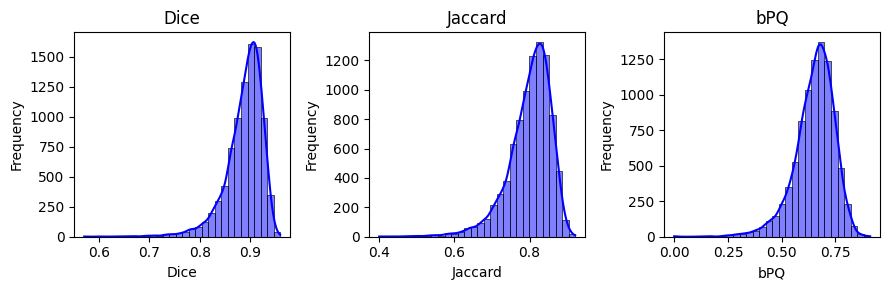

In [34]:
plot_all_metrics(df_metrics)

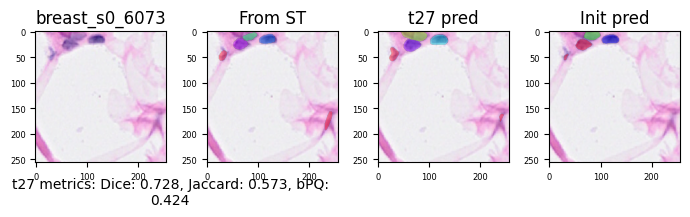

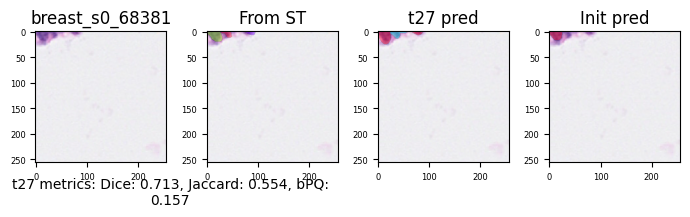

In [35]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [36]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for breast_s1

In [37]:
slide_id = "breast_s1"

In [38]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
10         breast_s1_780  0.819413  0.694073  0.694071   
13         breast_s1_785  0.860603  0.755314  0.744259   
35        breast_s1_1307  0.823327  0.699707  0.705325   
37        breast_s1_1309  0.847959  0.736050  0.597213   
53        breast_s1_1569  0.644951  0.475962  0.615013   
...                  ...       ...       ...       ...   
119944  breast_s1_147362  0.934026  0.876219  0.704785   
119963  breast_s1_147626  0.924891  0.860276  0.569271   
119964  breast_s1_147627  0.919950  0.851766  0.662992   
119966  breast_s1_147629  0.903033  0.823210  0.662938   
119974  breast_s1_147637  0.897708  0.814401  0.635080   

                                    type_proba_per_nuclei  
10       {'Fibroblast_Myofibroblast': 0.9999999974226804}  
13         {'Fibroblast_Myofibroblast': 0.99818181727438}  
35      {'Blood_vessel': 0.9726027382456579, 'T_NK': 0...  
37      {'T_NK': 0.9947780652877858, 'Myeloid': 0.3846...  
53      {'Fibroblast_Myofibroblast': 0.978260858931947...  
...                                                   ...  
119944  {'Myeloid': 0.977011488637865, 'Epithelial': 0...  
119963  {'Myeloid': 0.9670781879738296, 'Epithelial': ...  
119964  {'Epithelial': 0.993371211650866, 'Myeloid': 0...  
119966  {'Epithelial': 0.9351851765260633, 'Myeloid': ...  
119974                 {'Epithelial': 0.9999999955752212}  

[21738 rows x 5 columns]

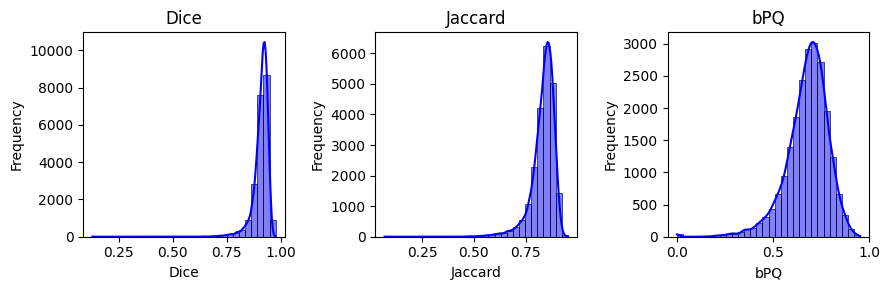

In [39]:
plot_all_metrics(df_metrics)

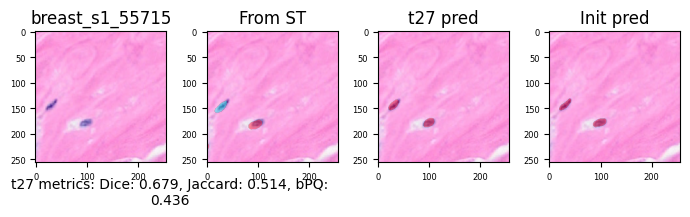

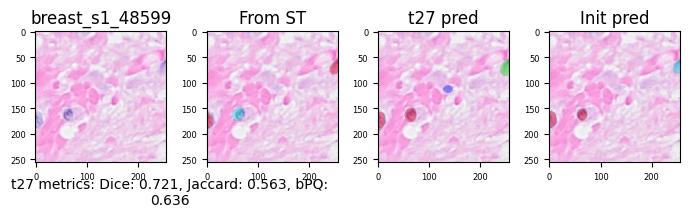

In [40]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [41]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for breast_s3

In [42]:
slide_id = "breast_s3"

In [43]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
29       breast_s3_357  0.802852  0.670637  0.501567   
41       breast_s3_525  0.970436  0.942571  0.635096   
53       breast_s3_550  0.842857  0.728395  0.728394   
71       breast_s3_583  0.822723  0.698836  0.468556   
77       breast_s3_589  0.895370  0.810562  0.732741   
...                ...       ...       ...       ...   
34558  breast_s3_49598  0.897242  0.813634  0.620253   
34560  breast_s3_49600  0.907540  0.830730  0.601041   
34566  breast_s3_49606  0.884091  0.792261  0.661554   
34599  breast_s3_49645  0.896543  0.812486  0.679314   
34602  breast_s3_49648  0.913030  0.839978  0.839963   

                                   type_proba_per_nuclei  
29     {'Epithelial': 0.9858870947865179, 'Myeloid': ...  
41      {'Fibroblast_Myofibroblast': 0.9924385623889994}  
53      {'Fibroblast_Myofibroblast': 0.7983193210225268}  
71     {'Epithelial': 0.6987951723036726, 'Blood_vess...  
77     {'Epithelial': 0.9149198509063874, 'Fibroblast...  
...                                                  ...  
34558                  {'Epithelial': 0.988571422922449}  
34560  {'Epithelial': 0.7236842010041553, 'Blood_vess...  
34566  {'Fibroblast_Myofibroblast': 0.998692809152035...  
34599  {'Myeloid': 0.7978723361815301, 'Epithelial': ...  
34602                  {'Epithelial': 0.956815113418603}  

[6442 rows x 5 columns]

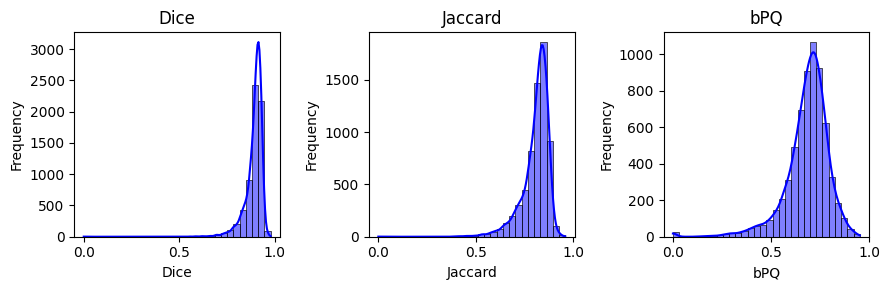

In [44]:
plot_all_metrics(df_metrics)

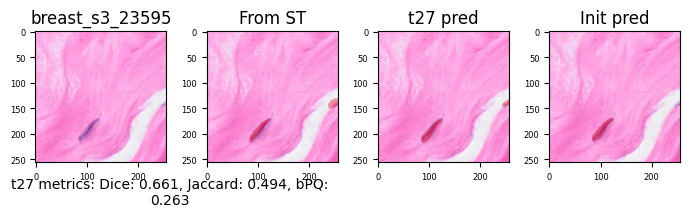

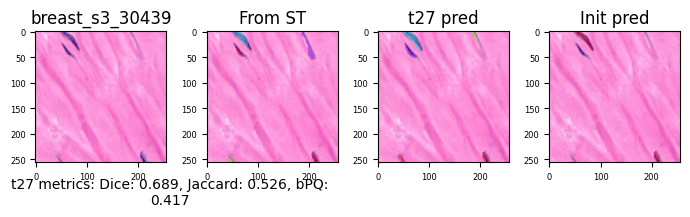

In [45]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [46]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for breast_s6

In [47]:
slide_id = "breast_s6"

In [48]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
25       breast_s6_358  0.877828  0.782258  0.550454   
26       breast_s6_359  0.884951  0.793643  0.781317   
44       breast_s6_417  0.816473  0.689864  0.620203   
65       breast_s6_652  0.688949  0.525493  0.392435   
66       breast_s6_653  0.777845  0.636453  0.497667   
...                ...       ...       ...       ...   
46809  breast_s6_55723  0.840169  0.724389  0.511840   
46821  breast_s6_55735  0.841786  0.726797  0.577463   
46879  breast_s6_55800  0.870085  0.770045  0.586127   
46933  breast_s6_56018  0.741384  0.589047  0.471047   
47010  breast_s6_56107  0.865618  0.763074  0.668539   

                                   type_proba_per_nuclei  
25     {'Dead': 0.7142857120181406, 'Blood_vessel': 0...  
26     {'Dead': 0.9645390002514964, 'Blood_vessel': 0...  
44     {'Blood_vessel': 0.76129032012487, 'Dead': 0.9...  
65     {'Dead': 0.537634405711643, 'Myeloid': 0.89999...  
66     {'Dead': 0.8910505801904647, 'Blood_vessel': 0...  
...                                                  ...  
46809                       {'Dead': 0.9793814332022532}  
46821  {'Dead': 0.7941176353806231, 'T_NK': 0.9798270...  
46879  {'Epithelial': 0.9827586191492812, 'Myeloid': ...  
46933  {'Dead': 0.9399999906000002, 'Epithelial': 0.8...  
47010  {'T_NK': 0.9016949121976444, 'Dead': 0.8849999...  

[6823 rows x 5 columns]

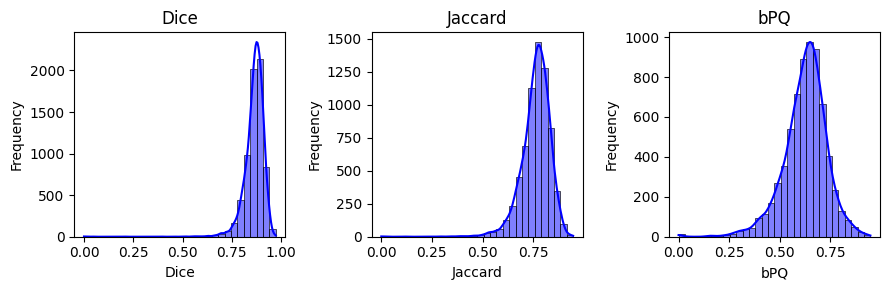

In [49]:
plot_all_metrics(df_metrics)

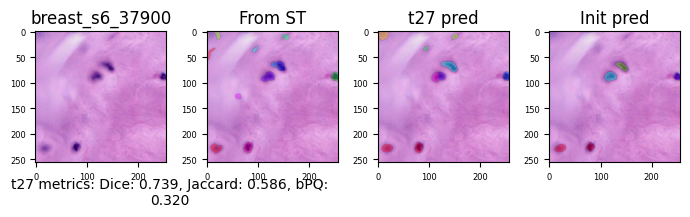

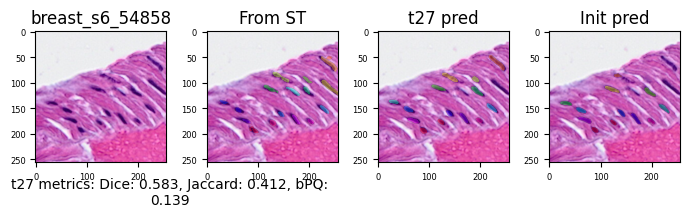

In [50]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [51]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for lung_s1

In [52]:
slide_id = "lung_s1"

In [53]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
28       lung_s1_444  0.736750  0.583217  0.598438   
31       lung_s1_447  0.909091  0.833333  0.848642   
37       lung_s1_453  0.944606  0.895028  0.762130   
39       lung_s1_455  0.886228  0.795699  0.605330   
42       lung_s1_467  0.691321  0.528259  0.444508   
...              ...       ...       ...       ...   
11250  lung_s1_16167  0.900433  0.818898  0.721804   
11260  lung_s1_16231  0.873794  0.775873  0.605012   
11269  lung_s1_16241  0.864013  0.760584  0.590334   
11272  lung_s1_16246  0.903095  0.823312  0.727593   
11293  lung_s1_16329  0.916404  0.845706  0.822614   

                                   type_proba_per_nuclei  
28     {'Blood_vessel': 0.9850746247652993, 'Myeloid'...  
31     {'Epithelial': 0.9518072231818843, 'Blood_vess...  
37     {'Blood_vessel': 0.9999999915966388, 'Epitheli...  
39     {'Blood_vessel': 0.9984051020759089, 'T_NK': 0...  
42     {'Blood_vessel': 0.5704622316003808, 'T_NK': 0...  
...                                                  ...  
11250  {'Blood_vessel': 0.993617019162517, 'Fibroblas...  
11260  {'Blood_vessel': 0.653543301940604, 'Myeloid':...  
11269  {'Myeloid': 0.980810232450298, 'Blood_vessel':...  
11272  {'Myeloid': 0.9971264339163034, 'T_NK': 0.9999...  
11293  {'Myeloid': 0.9999999982046679, 'T_NK': 0.9832...  

[2091 rows x 5 columns]

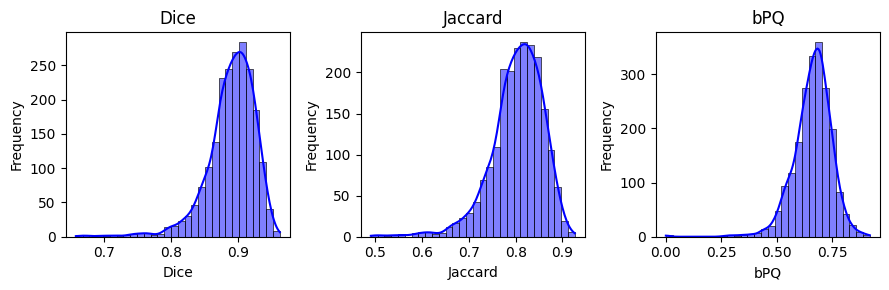

In [54]:
plot_all_metrics(df_metrics)

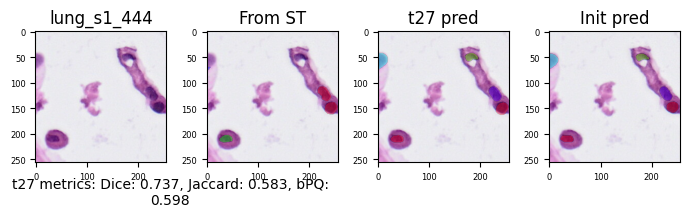

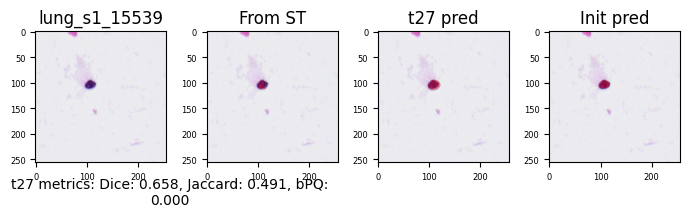

In [55]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [56]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for lung_s3

In [57]:
slide_id = "lung_s3"

In [58]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
12       lung_s3_294  0.700000  0.538462  0.353571   
25       lung_s3_420  0.882379  0.789515  0.800762   
30       lung_s3_425  0.841000  0.725625  0.657289   
31       lung_s3_426  0.854467  0.745913  0.680887   
37       lung_s3_432  0.878335  0.783063  0.696255   
...              ...       ...       ...       ...   
20907  lung_s3_30453  0.856410  0.748879  0.673908   
20932  lung_s3_30478  0.861665  0.756953  0.677567   
20935  lung_s3_30481  0.890208  0.802139  0.692874   
20943  lung_s3_30592  0.738162  0.584989  0.436835   
20971  lung_s3_30620  0.887574  0.797872  0.595964   

                                   type_proba_per_nuclei  
12     {'Epithelial': 0.9107551476993648, 'Fibroblast...  
25     {'Myeloid': 0.999999997206704, 'Epithelial': 0...  
30     {'T_NK': 0.9971590880762526, 'Epithelial': 0.9...  
31     {'Epithelial': 0.8758169877397582, 'Background...  
37     {'T_NK': 0.9859154901805197, 'B_Plasma': 0.999...  
...                                                  ...  
20907  {'Epithelial': 0.9663212410198931, 'Fibroblast...  
20932  {'B_Plasma': 0.8405405382688094, 'Fibroblast_M...  
20935  {'Epithelial': 0.8870431864217835, 'Blood_vess...  
20943  {'Fibroblast_Myofibroblast': 0.834558820461180...  
20971  {'Blood_vessel': 0.9602888051975134, 'Epitheli...  

[3432 rows x 5 columns]

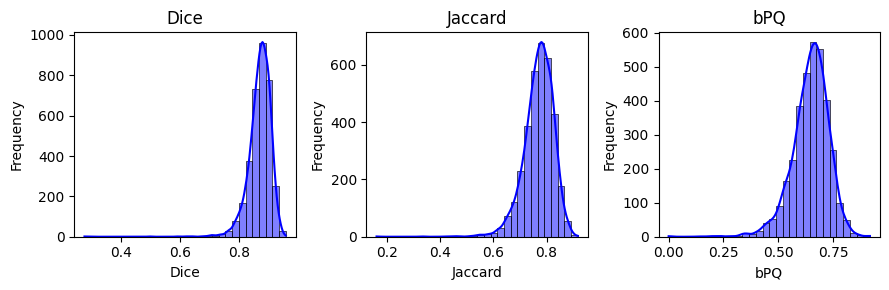

In [59]:
plot_all_metrics(df_metrics)

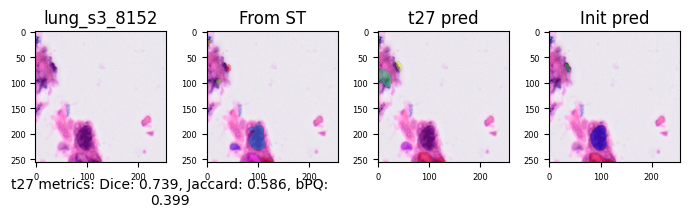

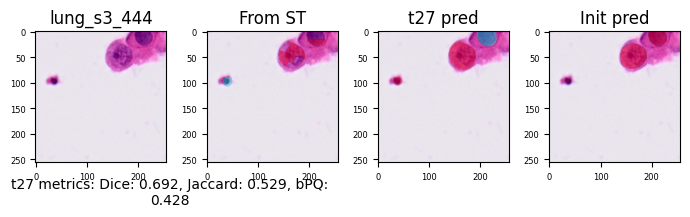

In [60]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [61]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for skin_s1

In [62]:
slide_id = "skin_s1"

In [63]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
18       skin_s1_352  0.872088  0.773188  0.717992   
20       skin_s1_354  0.892440  0.805771  0.705466   
23       skin_s1_357  0.831582  0.711717  0.545466   
26       skin_s1_360  0.901676  0.820957  0.749148   
35       skin_s1_456  0.820377  0.695457  0.448358   
...              ...       ...       ...       ...   
11613  skin_s1_16898  0.887716  0.798102  0.599496   
11614  skin_s1_16899  0.843198  0.728905  0.507440   
11622  skin_s1_16994  0.844471  0.730809  0.640938   
11623  skin_s1_16995  0.877417  0.781606  0.742675   
11629  skin_s1_17001  0.682705  0.518263  0.342153   

                                   type_proba_per_nuclei  
18     {'Epithelial': 0.9340659238014734, 'Dead': 0.5...  
20     {'Epithelial': 0.3999999980487805, 'Dead': 0.4...  
23     {'Epithelial': 0.05627705603343266, 'Dead': 0....  
26                        {'Epithelial': 0.994999995025}  
35     {'Epithelial': 0.5261044155578136, 'Melanocyte...  
...                                                  ...  
11613  {'Myeloid': 0.9765624974568685, 'Dead': 0.9608...  
11614  {'Fibroblast_Myofibroblast': 0.999999997340425...  
11622  {'Fibroblast_Myofibroblast': 0.951754384573458...  
11623  {'Fibroblast_Myofibroblast': 0.986666660088888...  
11629  {'Fibroblast_Myofibroblast': 0.999999995762711...  

[1135 rows x 5 columns]

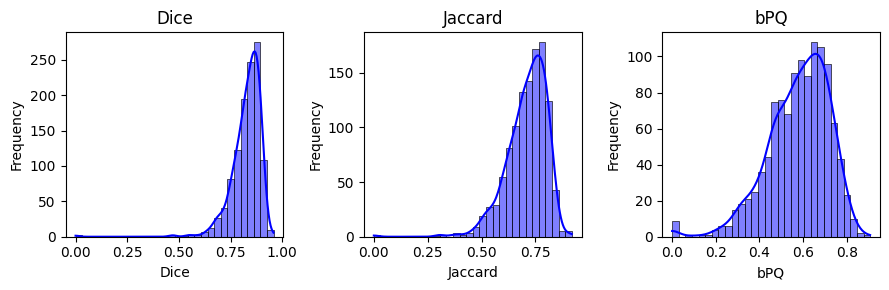

In [64]:
plot_all_metrics(df_metrics)

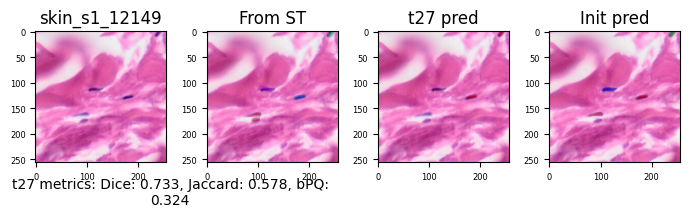

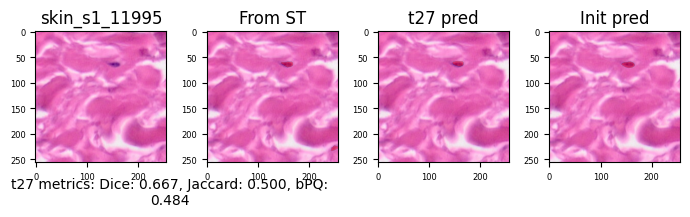

In [65]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [66]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for skin_s2

In [67]:
slide_id = "skin_s2"

In [68]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
5        skin_s2_220  0.933165  0.874704  0.411215   
10       skin_s2_335  0.914570  0.842588  0.668174   
15       skin_s2_450  0.857891  0.751147  0.651196   
16       skin_s2_451  0.883852  0.791878  0.723765   
23       skin_s2_566  0.913408  0.840617  0.754427   
...              ...       ...       ...       ...   
13188  skin_s2_25216  0.885770  0.794961  0.617504   
13193  skin_s2_25223  0.896066  0.811703  0.736962   
13198  skin_s2_25329  0.811249  0.682438  0.641635   
13208  skin_s2_25442  0.838302  0.721619  0.468825   
13211  skin_s2_25445  0.790766  0.653939  0.448064   

                                   type_proba_per_nuclei  
5                     {'Epithelial': 0.9838709657583247}  
10                    {'Epithelial': 0.9919954253905114}  
15                    {'Epithelial': 0.9999999964285714}  
16                    {'Epithelial': 0.9526813850073143}  
23                     {'Epithelial': 0.995073886723774}  
...                                                  ...  
13188               {'Blood_vessel': 0.9980013317801456}  
13193  {'Fibroblast_Myofibroblast': 0.962851404655771...  
13198  {'Myeloid': 0.6005221916435451, 'Epithelial': ...  
13208                 {'Epithelial': 0.9908141958284701}  
13211  {'Epithelial': 0.993630570083979, 'Fibroblast_...  

[2272 rows x 5 columns]

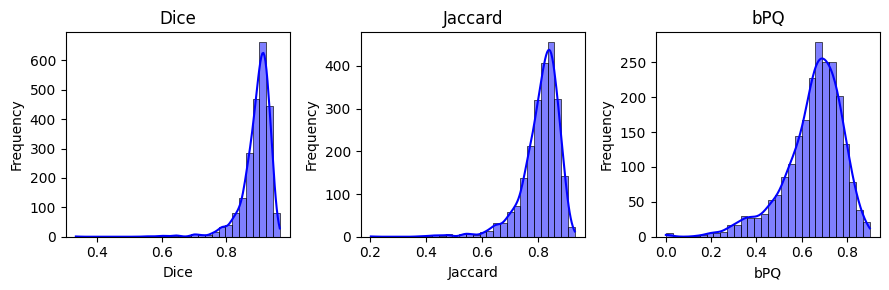

In [69]:
plot_all_metrics(df_metrics)

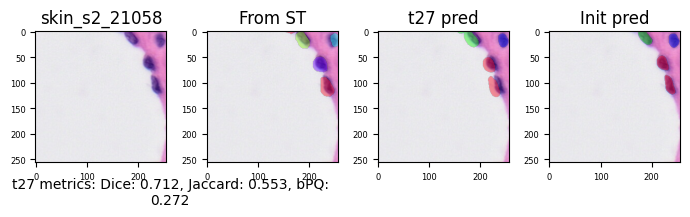

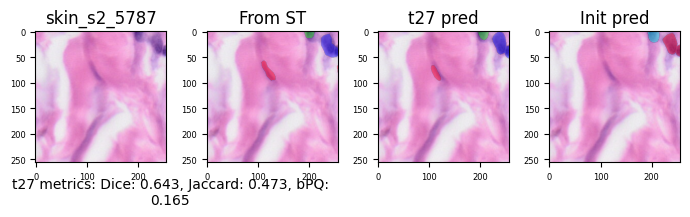

In [70]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [71]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for skin_s3

In [72]:
slide_id = "skin_s3"

In [73]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
12      skin_s3_242  0.659960  0.492492  0.000000   
28      skin_s3_348  0.822321  0.698255  0.694297   
30      skin_s3_350  0.851895  0.742000  0.615856   
31      skin_s3_351  0.843678  0.729622  0.622003   
42      skin_s3_451  0.820989  0.696337  0.627521   
...             ...       ...       ...       ...   
5930  skin_s3_11615  0.897021  0.813270  0.747295   
5944  skin_s3_11723  0.916713  0.846233  0.763652   
5956  skin_s3_11831  0.870453  0.770622  0.670753   
5964  skin_s3_11936  0.849896  0.738973  0.610023   
5977  skin_s3_12147  0.837375  0.720246  0.653358   

                                  type_proba_per_nuclei  
12                   {'Epithelial': 0.8015564186740147}  
28    {'Fibroblast_Myofibroblast': 0.991428568595918...  
30    {'Myeloid': 0.8653846130071852, 'Blood_vessel'...  
31    {'Blood_vessel': 0.8885869541071006, 'Fibrobla...  
42    {'Dead': 0.5785123919131208, 'Epithelial': 0.9...  
...                                                 ...  
5930  {'Epithelial': 0.9929077943765405, 'Dead': 0.6...  
5944  {'Epithelial': 0.9795918334027489, 'Background...  
5956  {'T_NK': 0.6816326502790504, 'Epithelial': 0.9...  
5964  {'Fibroblast_Myofibroblast': 0.903614446944404...  
5977  {'Epithelial': 0.9389671317419384, 'Fibroblast...  

[964 rows x 5 columns]

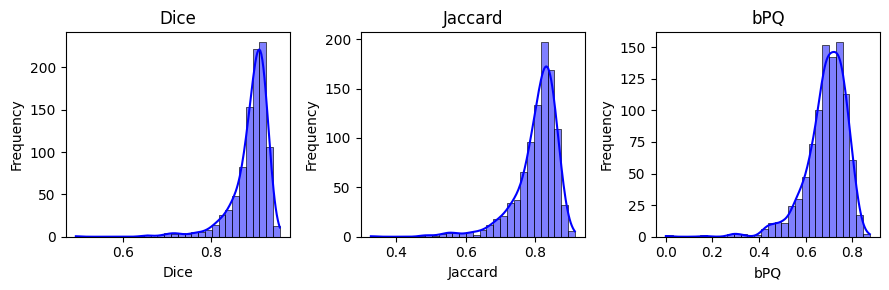

In [74]:
plot_all_metrics(df_metrics)

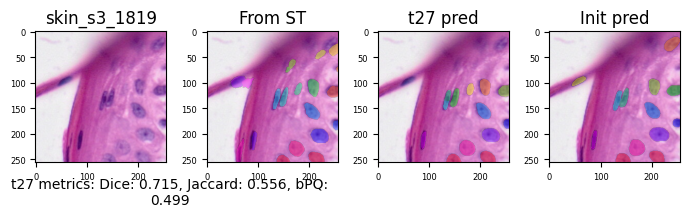

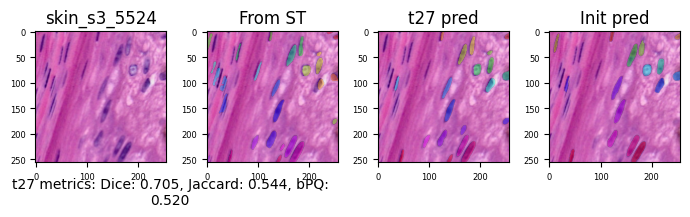

In [75]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [76]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for skin_s4

In [77]:
slide_id = "skin_s4"

In [78]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
23      skin_s4_619  0.782331  0.642483  0.609524   
44      skin_s4_724  0.912018  0.838266  0.735325   
82      skin_s4_908  0.881971  0.788863  0.650909   
87      skin_s4_913  0.855992  0.748240  0.663550   
90      skin_s4_916  0.946346  0.898156  0.759748   
...             ...       ...       ...       ...   
5901  skin_s4_17036  0.901671  0.820948  0.649681   
5904  skin_s4_17039  0.758356  0.610767  0.505037   
5906  skin_s4_17041  0.820691  0.695908  0.598298   
5912  skin_s4_17047  0.835398  0.717325  0.540301   
5927  skin_s4_17122  0.672574  0.506675  0.570454   

                                  type_proba_per_nuclei  
23    {'Fibroblast_Myofibroblast': 0.795969771294786...  
44    {'Epithelial': 0.9999999987309645, 'Dead': 0.9...  
82    {'Epithelial': 0.9969418929757129, 'Dead': 0.0...  
87    {'Epithelial': 0.9999999928057555, 'T_NK': 0.9...  
90                   {'Epithelial': 0.9635036426021633}  
...                                                 ...  
5901                 {'Melanocyte': 0.9999999942857143}  
5904  {'T_NK': 0.46242774299174716, 'Fibroblast_Myof...  
5906  {'Dead': 0.8378378302897493, 'Fibroblast_Myofi...  
5912  {'Melanocyte': 0.9778869754843071, 'T_NK': 0.9...  
5927  {'Melanocyte': 0.9925650520722489, 'Blood_vess...  

[1104 rows x 5 columns]

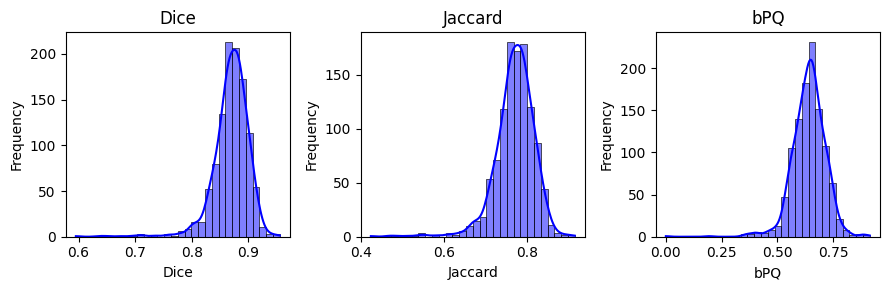

In [79]:
plot_all_metrics(df_metrics)

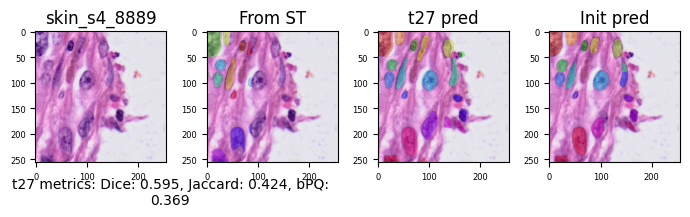

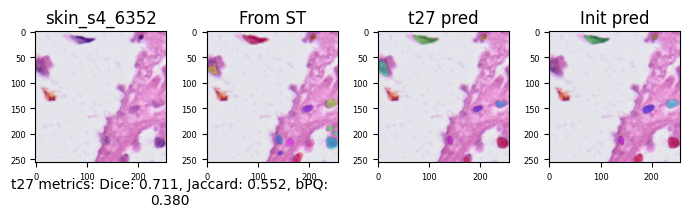

In [80]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [81]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for pancreatic_s0

In [82]:
slide_id = "pancreatic_s0"

In [83]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
35       pancreatic_s0_378  0.836150  0.718435  0.432478   
39       pancreatic_s0_382  0.776805  0.635062  0.538239   
41       pancreatic_s0_433  0.746544  0.595588  0.595587   
44       pancreatic_s0_436  0.842223  0.727449  0.529660   
56       pancreatic_s0_463  0.872960  0.774559  0.474934   
...                    ...       ...       ...       ...   
26102  pancreatic_s0_39260  0.833938  0.715175  0.420957   
26117  pancreatic_s0_39471  0.815301  0.688193  0.412480   
26118  pancreatic_s0_39472  0.778382  0.637173  0.628306   
26123  pancreatic_s0_39578  0.787640  0.649675  0.447710   
26133  pancreatic_s0_39948  0.720919  0.563623  0.433505   

                                   type_proba_per_nuclei  
35     {'Fibroblast_Myofibroblast': 0.986622071928725...  
39     {'Myeloid': 0.9581280764578126, 'Fibroblast_My...  
41      {'Fibroblast_Myofibroblast': 0.3960396000392119}  
44      {'Fibroblast_Myofibroblast': 0.9494117635889273}  
56     {'T_NK': 0.9597701094266086, 'Myeloid': 0.9999...  
...                                                  ...  
26102   {'Fibroblast_Myofibroblast': 0.8815789415685596}  
26117    {'Fibroblast_Myofibroblast': 0.955357141151148}  
26118                 {'Epithelial': 0.8967611317879329}  
26123  {'Fibroblast_Myofibroblast': 0.999999999162479...  
26133   {'Fibroblast_Myofibroblast': 0.9726984120808263}  

[3972 rows x 5 columns]

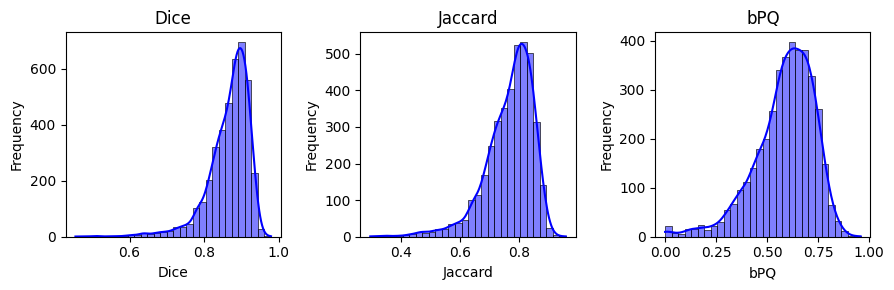

In [84]:
plot_all_metrics(df_metrics)

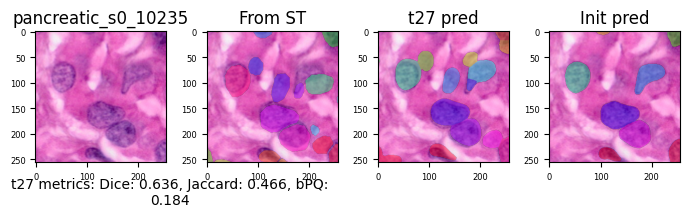

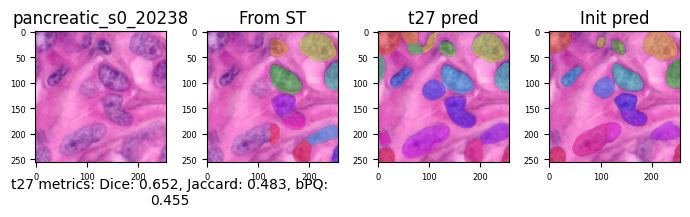

In [85]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [86]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for pancreatic_s1

In [87]:
slide_id = "pancreatic_s1"

In [88]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
10       pancreatic_s1_409  0.876712  0.780488  0.780486   
13       pancreatic_s1_413  0.848018  0.736138  0.435863   
15       pancreatic_s1_415  0.882026  0.788950  0.698505   
29       pancreatic_s1_510  0.828767  0.707602  0.700029   
30       pancreatic_s1_511  0.816700  0.690188  0.574045   
...                    ...       ...       ...       ...   
12755  pancreatic_s1_20500  0.851589  0.741536  0.580864   
12756  pancreatic_s1_20501  0.870149  0.770144  0.619726   
12764  pancreatic_s1_20509  0.813625  0.685808  0.433138   
12774  pancreatic_s1_20595  0.795745  0.660779  0.492299   
12779  pancreatic_s1_20600  0.849126  0.737809  0.399093   

                                   type_proba_per_nuclei  
10                           {'T_NK': 0.999999997260274}  
13     {'Myeloid': 0.9943977563182136, 'Fibroblast_My...  
15     {'Fibroblast_Myofibroblast': 0.523605147967359...  
29     {'Background': 0.9999999904761906, 'Myeloid': ...  
30     {'Background': 0.9999999787234047, 'Fibroblast...  
...                                                  ...  
12755  {'Epithelial': 0.777173908819707, 'Dead': 0.93...  
12756  {'Epithelial': 0.9531249962768555, 'Dead': 0.9...  
12764  {'Myeloid': 0.3532608676453214, 'B_Plasma': 0....  
12774  {'Epithelial': 0.9924170606706946, 'Fibroblast...  
12779  {'Dead': 0.9848484798745026, 'Epithelial': 0.5...  

[2227 rows x 5 columns]

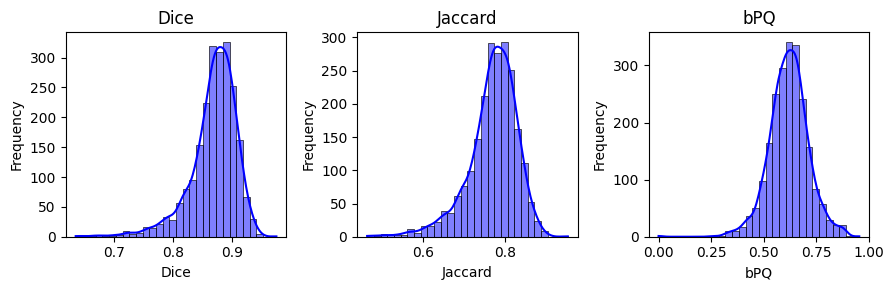

In [89]:
plot_all_metrics(df_metrics)

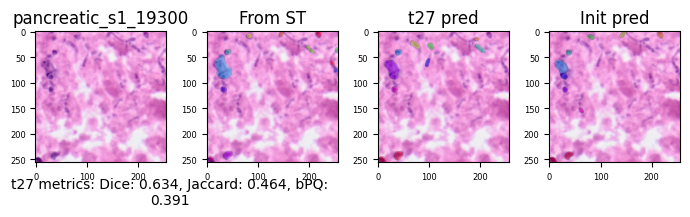

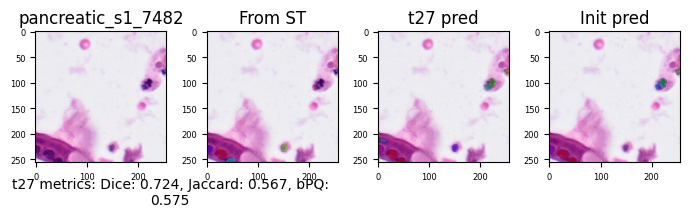

In [90]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [91]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for pancreatic_s2

In [92]:
slide_id = "pancreatic_s2"

In [93]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
1       pancreatic_s2_243  0.722623  0.565709  0.512601   
28      pancreatic_s2_404  0.834409  0.715868  0.407220   
29      pancreatic_s2_405  0.849733  0.738727  0.581463   
55      pancreatic_s2_492  0.813222  0.685235  0.483985   
102     pancreatic_s2_650  0.842278  0.727530  0.502845   
...                   ...       ...       ...       ...   
6986  pancreatic_s2_10797  0.845239  0.731960  0.679432   
6993  pancreatic_s2_10804  0.827642  0.705963  0.612489   
6995  pancreatic_s2_10806  0.883361  0.791090  0.592281   
6996  pancreatic_s2_10807  0.814708  0.687349  0.456682   
7009  pancreatic_s2_10898  0.804821  0.673390  0.529472   

                                  type_proba_per_nuclei  
1     {'Fibroblast_Myofibroblast': 0.995495494000757...  
28    {'Fibroblast_Myofibroblast': 0.923444971658158...  
29    {'Fibroblast_Myofibroblast': 0.972972967713659...  
55     {'Fibroblast_Myofibroblast': 0.9792531079699042}  
102   {'Dead': 0.987499993828125, 'Epithelial': 0.98...  
...                                                 ...  
6986  {'Epithelial': 0.9819004502671935, 'T_NK': 0.6...  
6993                 {'Epithelial': 0.9999999939024391}  
6995  {'Epithelial': 0.923913033435728, 'Blood_vesse...  
6996  {'Fibroblast_Myofibroblast': 0.992217896902299...  
7009  {'Epithelial': 0.8744186005840996, 'Background...  

[1245 rows x 5 columns]

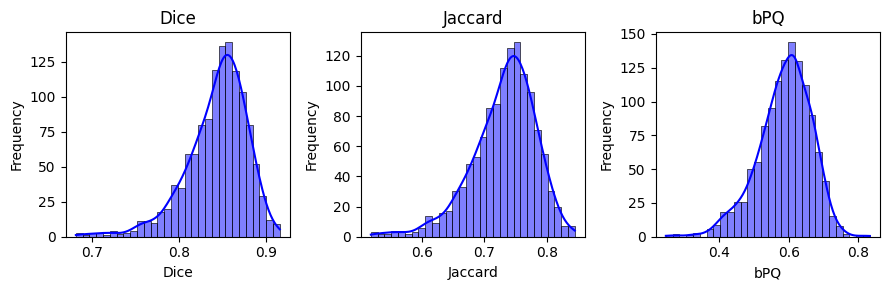

In [94]:
plot_all_metrics(df_metrics)

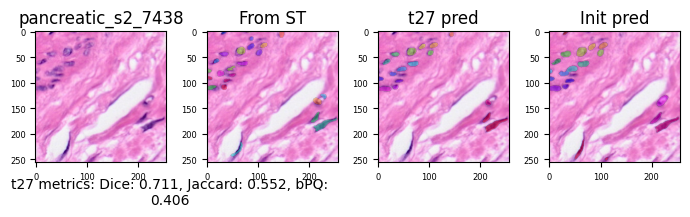

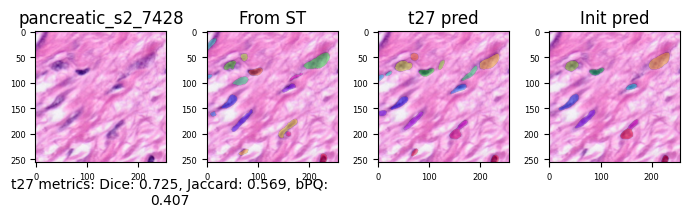

In [95]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [96]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for heart_s0

In [97]:
slide_id = "heart_s0"

In [98]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
8      heart_s0_366  0.901961  0.821429  0.833332   
29     heart_s0_481  0.879370  0.784710  0.709168   
31     heart_s0_483  0.931694  0.872123  0.754312   
36     heart_s0_488  0.904529  0.825698  0.727358   
65     heart_s0_578  0.822376  0.698336  0.613953   
...             ...       ...       ...       ...   
5474  heart_s0_6691  0.827950  0.706412  0.407849   
5512  heart_s0_6731  0.707750  0.547688  0.384598   
5521  heart_s0_6789  0.824074  0.700787  0.630736   
5522  heart_s0_6790  0.867609  0.766174  0.754088   
5523  heart_s0_6791  0.722683  0.565782  0.520964   

                                  type_proba_per_nuclei  
8                   {'Specialized': 0.9960937480545045}  
29    {'Blood_vessel': 0.7990430583777844, 'Speciali...  
31    {'Blood_vessel': 0.9182389879356039, 'Speciali...  
36    {'Fibroblast_Myofibroblast': 0.925465836593238...  
65    {'Specialized': 0.9999999910714287, 'Blood_ves...  
...                                                 ...  
5474                 {'Epithelial': 0.9999999965156795}  
5512   {'Fibroblast_Myofibroblast': 0.9999999959183674}  
5521   {'Fibroblast_Myofibroblast': 0.6747967424813273}  
5522  {'Blood_vessel': 0.5033112549449585, 'Speciali...  
5523  {'Fibroblast_Myofibroblast': 0.952141055536168...  

[963 rows x 5 columns]

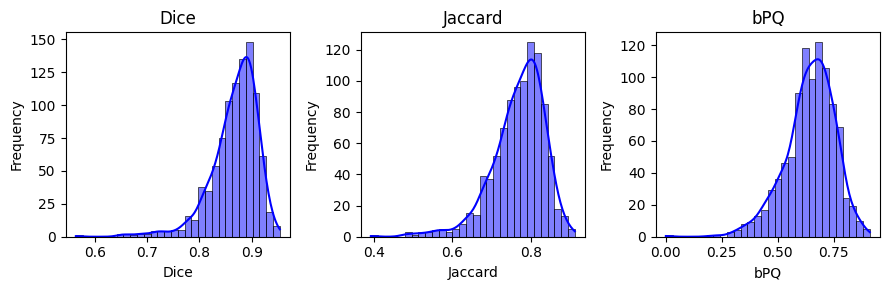

In [99]:
plot_all_metrics(df_metrics)

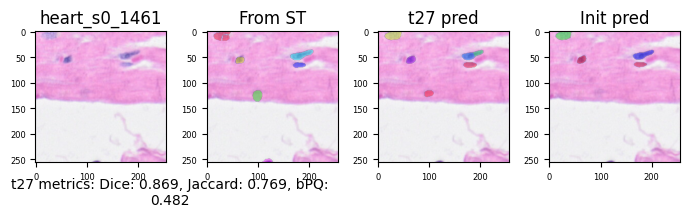

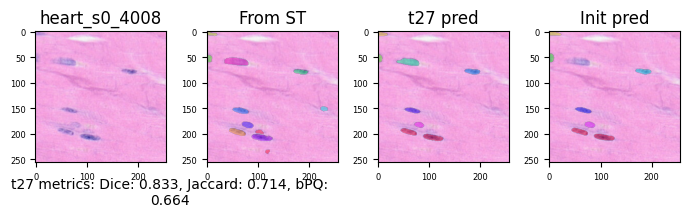

In [100]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.5, 
            high_threshold=0.8, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [101]:
# plot_patch_seg(patch_id="heart_s0_500", 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for colon_s1

In [102]:
slide_id = "colon_s1"

In [103]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
114     colon_s1_5394  0.784654  0.645622  0.275720   
118     colon_s1_5398  0.596802  0.425315  0.015375   
124     colon_s1_5404  0.803606  0.671690  0.496432   
126     colon_s1_5406  0.861487  0.756678  0.475228   
129     colon_s1_5409  0.869335  0.768870  0.634292   
...               ...       ...       ...       ...   
18326  colon_s1_27904  0.893646  0.807739  0.571550   
18329  colon_s1_27907  0.887913  0.798420  0.609644   
18331  colon_s1_27909  0.868690  0.767862  0.505771   
18449  colon_s1_28169  0.855911  0.748116  0.495029   
18761  colon_s1_29045  0.744216  0.592631  0.378986   

                                   type_proba_per_nuclei  
114    {'Epithelial': 0.968468464105998, 'Myeloid': 0...  
118    {'T_NK': 0.9535603685648286, 'Fibroblast_Myofi...  
124    {'Epithelial': 0.9563106780642222, 'Myeloid': ...  
126    {'Myeloid': 0.9166666645447531, 'T_NK': 0.9829...  
129    {'Fibroblast_Myofibroblast': 0.983766232169210...  
...                                                  ...  
18326                 {'Epithelial': 0.9923076884911243}  
18329  {'Epithelial': 0.9956331834251826, 'Myeloid': ...  
18331  {'Epithelial': 0.9729729642074508, 'Myeloid': ...  
18449                 {'Epithelial': 0.9999999918699188}  
18761    {'Fibroblast_Myofibroblast': 0.997375326775098}  

[2184 rows x 5 columns]

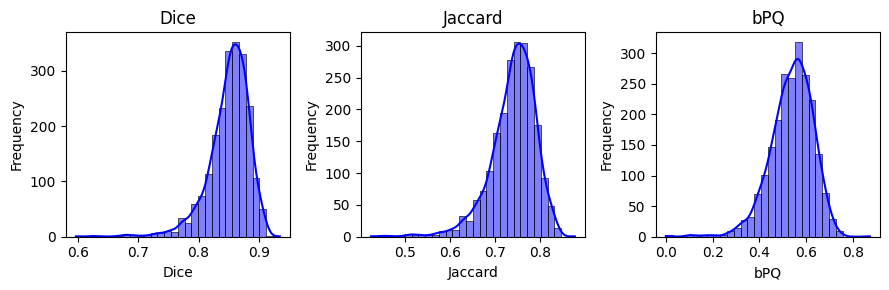

In [104]:
plot_all_metrics(df_metrics)

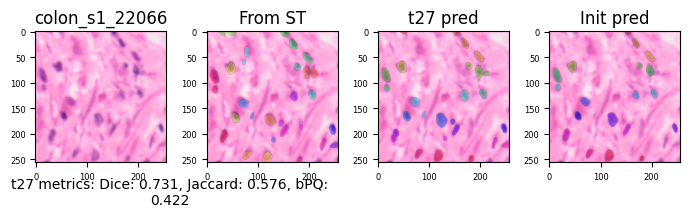

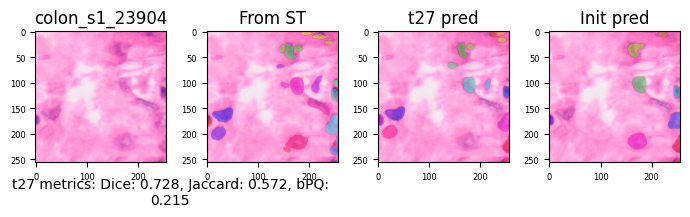

In [105]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [106]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for colon_s2

In [107]:
slide_id = "colon_s1"

In [108]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
114     colon_s1_5394  0.784654  0.645622  0.275720   
118     colon_s1_5398  0.596802  0.425315  0.015375   
124     colon_s1_5404  0.803606  0.671690  0.496432   
126     colon_s1_5406  0.861487  0.756678  0.475228   
129     colon_s1_5409  0.869335  0.768870  0.634292   
...               ...       ...       ...       ...   
18326  colon_s1_27904  0.893646  0.807739  0.571550   
18329  colon_s1_27907  0.887913  0.798420  0.609644   
18331  colon_s1_27909  0.868690  0.767862  0.505771   
18449  colon_s1_28169  0.855911  0.748116  0.495029   
18761  colon_s1_29045  0.744216  0.592631  0.378986   

                                   type_proba_per_nuclei  
114    {'Epithelial': 0.968468464105998, 'Myeloid': 0...  
118    {'T_NK': 0.9535603685648286, 'Fibroblast_Myofi...  
124    {'Epithelial': 0.9563106780642222, 'Myeloid': ...  
126    {'Myeloid': 0.9166666645447531, 'T_NK': 0.9829...  
129    {'Fibroblast_Myofibroblast': 0.983766232169210...  
...                                                  ...  
18326                 {'Epithelial': 0.9923076884911243}  
18329  {'Epithelial': 0.9956331834251826, 'Myeloid': ...  
18331  {'Epithelial': 0.9729729642074508, 'Myeloid': ...  
18449                 {'Epithelial': 0.9999999918699188}  
18761    {'Fibroblast_Myofibroblast': 0.997375326775098}  

[2184 rows x 5 columns]

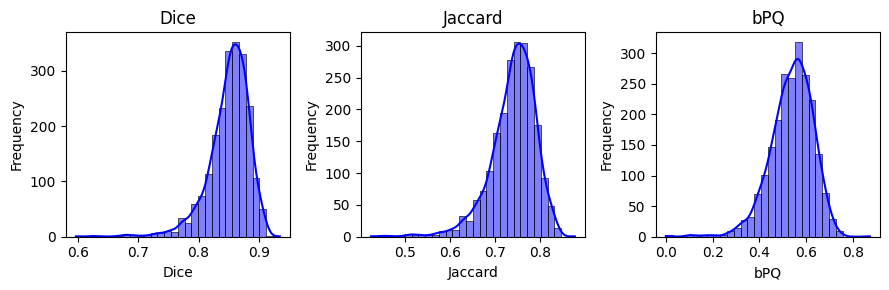

In [109]:
plot_all_metrics(df_metrics)

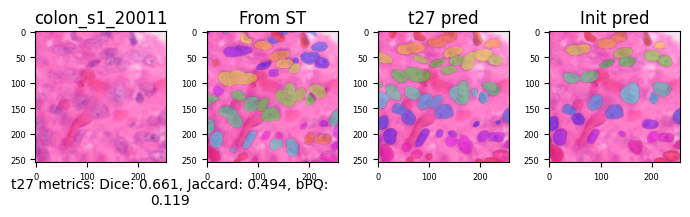

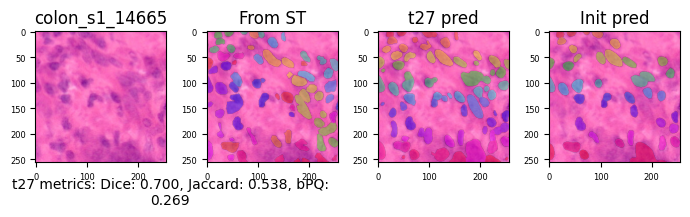

In [110]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [111]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for kidney_s0

In [112]:
slide_id = "kidney_s0"

In [113]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
2       kidney_s0_189  0.834297  0.715703  0.686515   
3       kidney_s0_190  0.857818  0.751034  0.737631   
5       kidney_s0_192  0.805196  0.673915  0.670776   
6       kidney_s0_193  0.782969  0.643344  0.529847   
10      kidney_s0_197  0.699241  0.537564  0.513582   
...               ...       ...       ...       ...   
6932  kidney_s0_10614  0.938948  0.884922  0.740167   
6933  kidney_s0_10615  0.886499  0.796137  0.752687   
6939  kidney_s0_10621  0.881694  0.788420  0.759504   
6946  kidney_s0_10675  0.808149  0.678063  0.520218   
6947  kidney_s0_10676  0.828625  0.707395  0.707394   

                                  type_proba_per_nuclei  
2     {'Fibroblast_Myofibroblast': 0.769841263731418...  
3     {'Epithelial': 0.9813664535318855, 'Blood_vess...  
5     {'Epithelial': 0.9288537512693528, 'T_NK': 0.2...  
6     {'Epithelial': 0.977220954493802, 'Blood_vesse...  
10    {'Blood_vessel': 0.9935275048753155, 'Epitheli...  
...                                                 ...  
6932  {'T_NK': 0.32307692142011835, 'Epithelial': 0....  
6933  {'Epithelial': 0.8294573579111832, 'Blood_vess...  
6939  {'T_NK': 0.7570621447540617, 'Fibroblast_Myofi...  
6946   {'Fibroblast_Myofibroblast': 0.7765151485738062}  
6947                 {'Epithelial': 0.7420634891187957}  

[1348 rows x 5 columns]

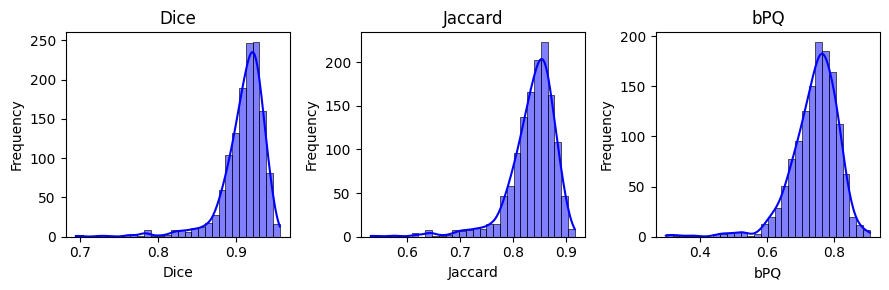

In [114]:
plot_all_metrics(df_metrics)

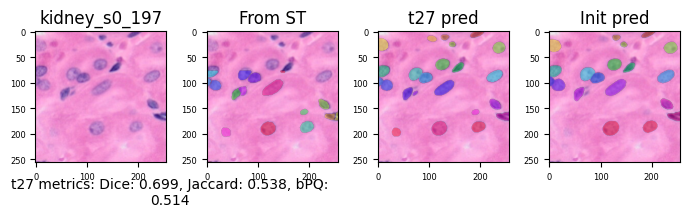

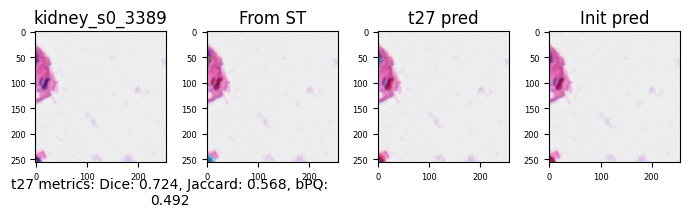

In [115]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [116]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for kidney_s1

In [117]:
slide_id = "kidney_s1"

In [118]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
15     kidney_s1_147  0.908739  0.832742  0.710149   
16     kidney_s1_148  0.917618  0.847776  0.640572   
68     kidney_s1_208  0.894184  0.808619  0.646733   
78     kidney_s1_218  0.893677  0.807791  0.643977   
79     kidney_s1_219  0.889328  0.800712  0.694374   
...              ...       ...       ...       ...   
4707  kidney_s1_6306  0.871651  0.772501  0.624536   
4708  kidney_s1_6307  0.771896  0.628527  0.299960   
4716  kidney_s1_6321  0.921754  0.854864  0.571428   
4718  kidney_s1_6323  0.764426  0.618681  0.618341   
4778  kidney_s1_6410  0.912500  0.839080  0.862203   

                                  type_proba_per_nuclei  
15    {'Myeloid': 0.1599999984, 'Fibroblast_Myofibro...  
16     {'Fibroblast_Myofibroblast': 0.9923076846745563}  
68    {'Fibroblast_Myofibroblast': 0.968127486182759...  
78       {'Fibroblast_Myofibroblast': 0.99999999864682}  
79    {'Fibroblast_Myofibroblast': 0.988721803272278...  
...                                                 ...  
4707  {'Myeloid': 0.994680848418402, 'Fibroblast_Myo...  
4708  {'Epithelial': 0.5795454479597109, 'Fibroblast...  
4716                    {'Myeloid': 0.9586919088490673}  
4718                    {'Myeloid': 0.9982964207865478}  
4778                 {'Epithelial': 0.9761904723167045}  

[854 rows x 5 columns]

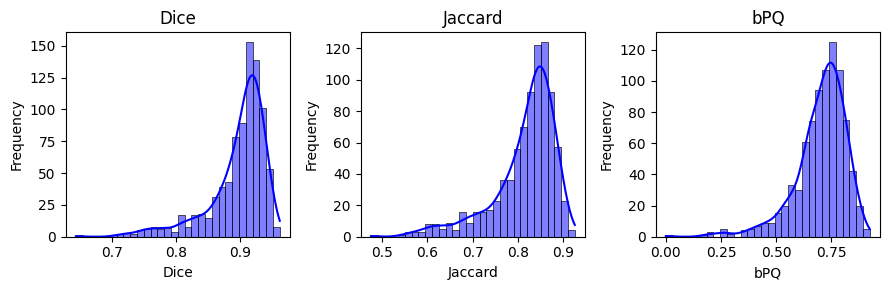

In [119]:
plot_all_metrics(df_metrics)

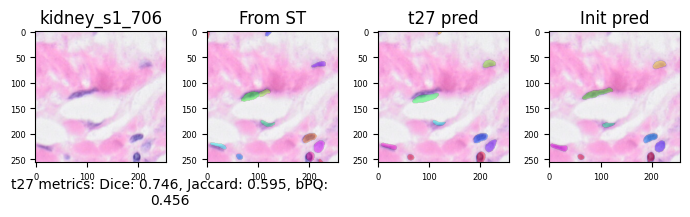

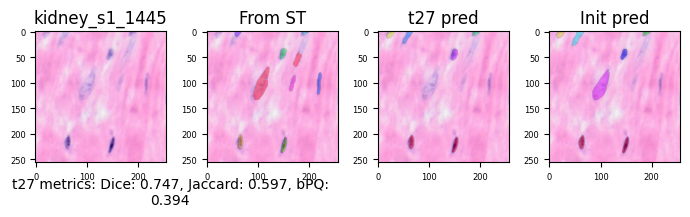

In [120]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [121]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for liver_s0

In [122]:
slide_id = "liver_s0"

In [123]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
30       liver_s0_367  0.765508  0.620099  0.523382   
62       liver_s0_507  0.852213  0.742484  0.589460   
65       liver_s0_510  0.855759  0.747884  0.666438   
68       liver_s0_513  0.803876  0.672068  0.524854   
71       liver_s0_516  0.873044  0.774693  0.642132   
...               ...       ...       ...       ...   
20817  liver_s0_30973  0.767420  0.622613  0.464268   
20821  liver_s0_30977  0.918849  0.849880  0.741159   
20823  liver_s0_30979  0.940201  0.887150  0.780636   
20825  liver_s0_30981  0.876269  0.779786  0.743012   
20858  liver_s0_31124  0.844138  0.730310  0.628704   

                                   type_proba_per_nuclei  
30     {'Myeloid': 0.9933110334671872, 'Epithelial': ...  
62     {'Epithelial': 0.9434447276518131, 'Blood_vess...  
65     {'Epithelial': 0.9634146317965497, 'Fibroblast...  
68     {'Epithelial': 0.8915662596893599, 'Myeloid': ...  
71     {'Epithelial': 0.9619377129344716, 'Blood_vess...  
...                                                  ...  
20817  {'Epithelial': 0.9531249970214843, 'Fibroblast...  
20821  {'Epithelial': 0.9862385275860618, 'Myeloid': ...  
20823  {'Epithelial': 0.9767441803677664, 'Myeloid': ...  
20825  {'Epithelial': 0.9999999956140351, 'Fibroblast...  
20858  {'Epithelial': 0.9163346595292138, 'Myeloid': ...  

[3817 rows x 5 columns]

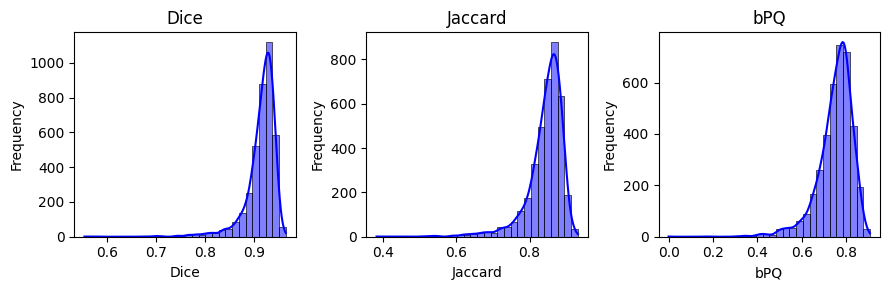

In [124]:
plot_all_metrics(df_metrics)

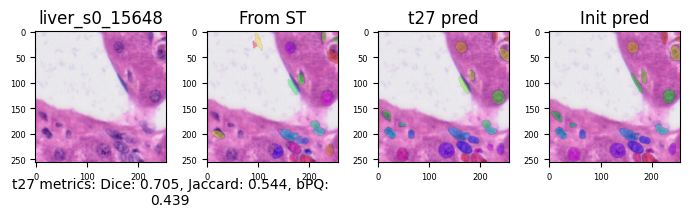

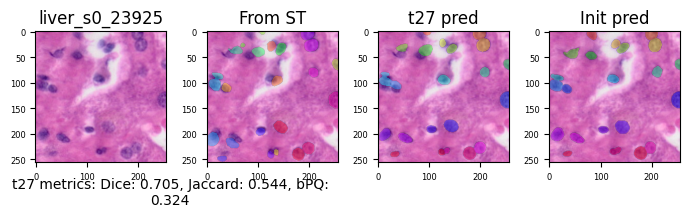

In [125]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [126]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for liver_s1

In [127]:
slide_id = "liver_s1"

In [128]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
4       liver_s1_249  0.871401  0.772108  0.500030   
8       liver_s1_253  0.865031  0.762162  0.637153   
16      liver_s1_262  0.849896  0.738973  0.639767   
18      liver_s1_292  0.874840  0.777525  0.760534   
20      liver_s1_323  0.893447  0.807415  0.613435   
...              ...       ...       ...       ...   
9615  liver_s1_13742  0.919871  0.851630  0.754128   
9616  liver_s1_13743  0.910608  0.835887  0.759827   
9626  liver_s1_13823  0.856072  0.748362  0.719328   
9638  liver_s1_13906  0.774684  0.632231  0.632230   
9640  liver_s1_13908  0.726368  0.570312  0.435416   

                                  type_proba_per_nuclei  
4                     {'Epithelial': 0.999999996923077}  
8                    {'Epithelial': 0.9427480880047783}  
16                   {'Epithelial': 0.9874999876562501}  
18    {'Blood_vessel': 0.7582159606614649, 'Epitheli...  
20                   {'Epithelial': 0.9712230145955179}  
...                                                 ...  
9615  {'Fibroblast_Myofibroblast': 0.983713353446721...  
9616  {'Myeloid': 0.9803921472510574, 'T_NK': 0.9677...  
9626  {'Fibroblast_Myofibroblast': 0.903225796739507...  
9638   {'Fibroblast_Myofibroblast': 0.9999999957983193}  
9640   {'Fibroblast_Myofibroblast': 0.9999999957264958}  

[1940 rows x 5 columns]

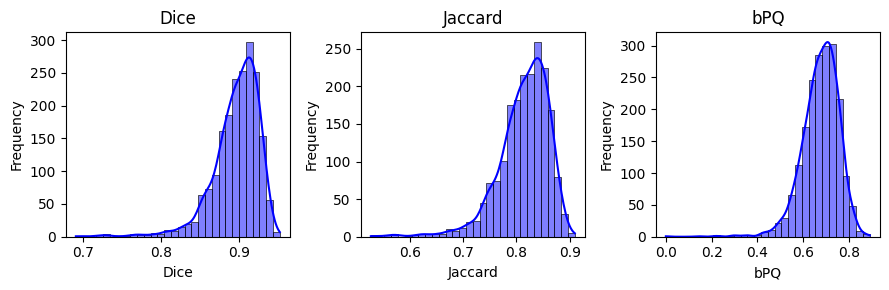

In [129]:
plot_all_metrics(df_metrics)

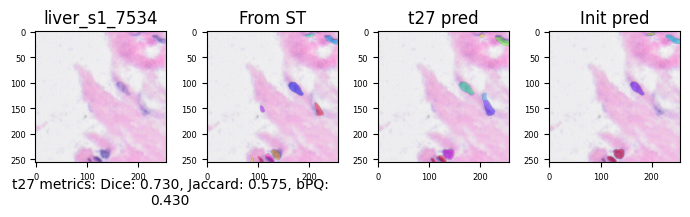

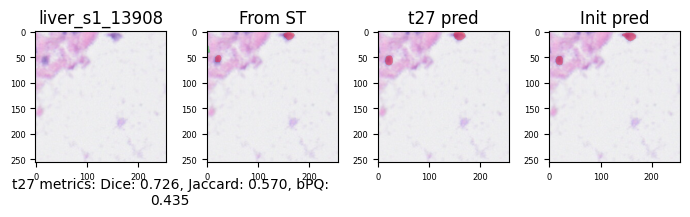

In [130]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [131]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for tonsil_s0

In [132]:
slide_id = "tonsil_s0"

In [133]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
19       tonsil_s0_683  0.859279  0.753277  0.550832   
21       tonsil_s0_685  0.875365  0.778355  0.614675   
28       tonsil_s0_848  0.841904  0.726973  0.547974   
31       tonsil_s0_851  0.831425  0.711486  0.475684   
44      tonsil_s0_1179  0.856628  0.749212  0.563187   
...                ...       ...       ...       ...   
23358  tonsil_s0_34869  0.946368  0.898196  0.803227   
23385  tonsil_s0_35195  0.859758  0.754014  0.755865   
23386  tonsil_s0_35196  0.926156  0.862467  0.654673   
23389  tonsil_s0_35199  0.879252  0.784523  0.722992   
23391  tonsil_s0_35201  0.780239  0.639666  0.497360   

                                   type_proba_per_nuclei  
19     {'Epithelial': 0.9770992291824486, 'Myeloid': ...  
21     {'Epithelial': 0.9352941121453288, 'T_NK': 0.9...  
28     {'B_Plasma': 0.5630252077183815, 'Epithelial':...  
31     {'T_NK': 0.7832512276687131, 'Epithelial': 0.8...  
44     {'T_NK': 0.9499999932142857, 'B_Plasma': 0.972...  
...                                                  ...  
23358                 {'Epithelial': 0.9939975978463415}  
23385                 {'Epithelial': 0.9887165007211333}  
23386                 {'Epithelial': 0.9920948596994172}  
23389                  {'Epithelial': 0.943037971699247}  
23391                 {'Epithelial': 0.9899999901000002}  

[4405 rows x 5 columns]

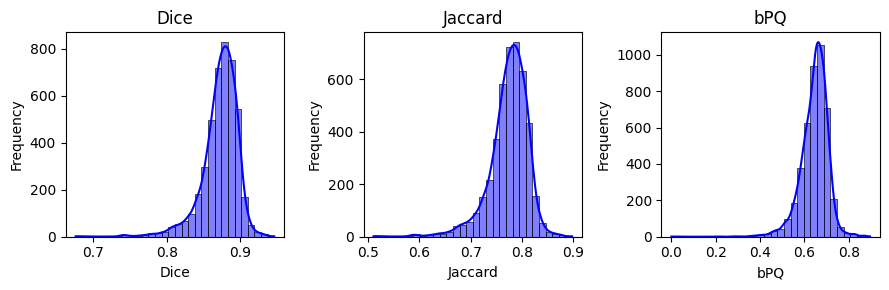

In [134]:
plot_all_metrics(df_metrics)

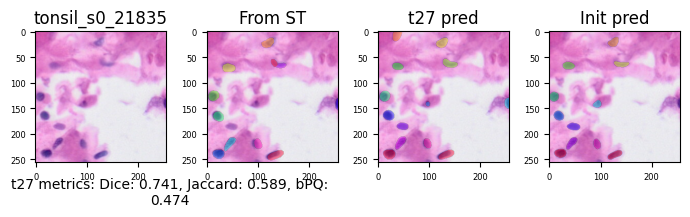

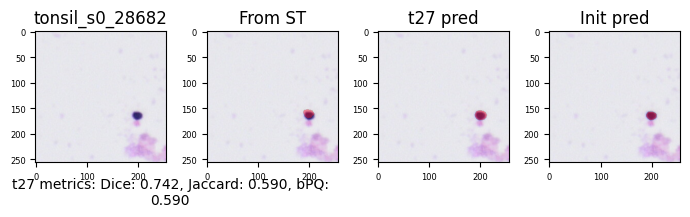

In [135]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [136]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for tonsil_s1

In [137]:
slide_id = "tonsil_s1"

In [138]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
66      tonsil_s1_1985  0.872140  0.773270  0.773268   
82      tonsil_s1_2232  0.827586  0.705882  0.705881   
103     tonsil_s1_2490  0.750207  0.600265  0.536295   
151     tonsil_s1_2991  0.775010  0.632666  0.522111   
174     tonsil_s1_3235  0.693364  0.530649  0.272443   
...                ...       ...       ...       ...   
21314  tonsil_s1_42617  0.866130  0.763871  0.609569   
21322  tonsil_s1_42625  0.782021  0.642064  0.540148   
21328  tonsil_s1_42859  0.804222  0.672551  0.521275   
21337  tonsil_s1_42868  0.909921  0.834730  0.713815   
21339  tonsil_s1_42870  0.888821  0.799891  0.631243   

                                   type_proba_per_nuclei  
66                    {'Epithelial': 0.2887828155398978}  
82                    {'Epithelial': 0.6493506482965087}  
103    {'Fibroblast_Myofibroblast': 0.820754713109647...  
151    {'Fibroblast_Myofibroblast': 0.963636354876033...  
174    {'Dead': 0.7395348802812332, 'Fibroblast_Myofi...  
...                                                  ...  
21314  {'B_Plasma': 0.9876543087943913, 'Epithelial':...  
21322                 {'Epithelial': 0.8888888747795417}  
21328                 {'Epithelial': 0.8843283549092226}  
21337                 {'Epithelial': 0.9330143496028022}  
21339                  {'Epithelial': 0.853658526174896}  

[3431 rows x 5 columns]

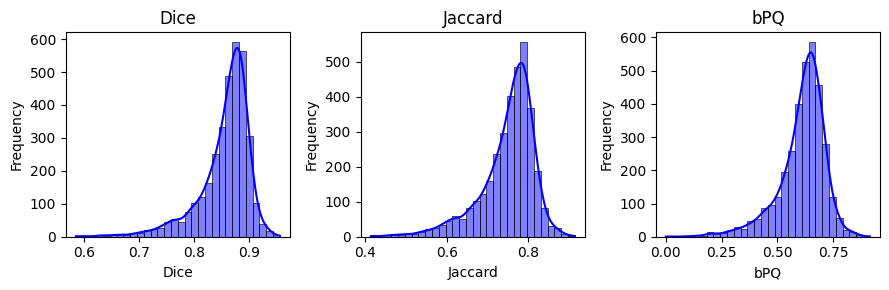

In [139]:
plot_all_metrics(df_metrics)

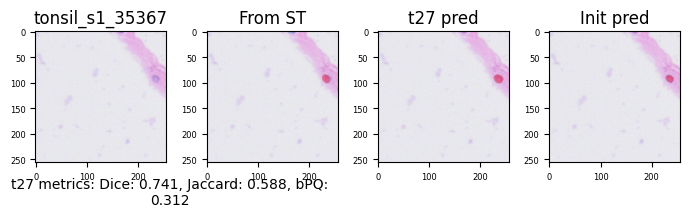

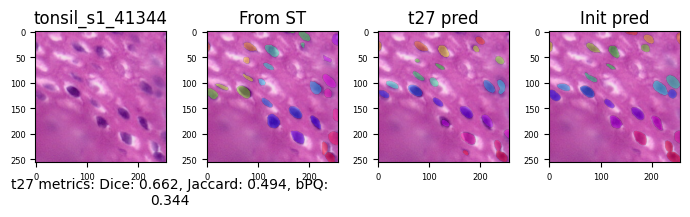

In [140]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [141]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for lymph_node_s0

In [142]:
slide_id = "lymph_node_s0"

In [143]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
4        lymph_node_s0_237  0.820410  0.695504  0.688876   
20       lymph_node_s0_536  0.754961  0.606375  0.530189   
24       lymph_node_s0_540  0.897554  0.814147  0.814145   
38       lymph_node_s0_684  0.804774  0.673324  0.606786   
41       lymph_node_s0_687  0.879048  0.784197  0.633321   
...                    ...       ...       ...       ...   
14247  lymph_node_s0_22998  0.914133  0.841847  0.811606   
14248  lymph_node_s0_23000  0.909091  0.833333  0.833332   
14250  lymph_node_s0_23005  0.769231  0.625000  0.590405   
14251  lymph_node_s0_23006  0.853035  0.743733  0.557426   
14254  lymph_node_s0_23012  0.794338  0.658840  0.537161   

                                   type_proba_per_nuclei  
4      {'Myeloid': 0.8939929297032052, 'Dead': 0.9506...  
20     {'Dead': 0.9768115913715606, 'Blood_vessel': 0...  
24      {'Fibroblast_Myofibroblast': 0.9999999985294118}  
38      {'Fibroblast_Myofibroblast': 0.9434628941927107}  
41     {'Fibroblast_Myofibroblast': 0.995594711463447...  
...                                                  ...  
14247  {'Blood_vessel': 0.9774436077976897, 'Fibrobla...  
14248   {'Fibroblast_Myofibroblast': 0.9980430508844559}  
14250  {'Fibroblast_Myofibroblast': 0.946360149630804...  
14251  {'Fibroblast_Myofibroblast': 0.19230768860946754}  
14254   {'Fibroblast_Myofibroblast': 0.9959595939475564}  

[2528 rows x 5 columns]

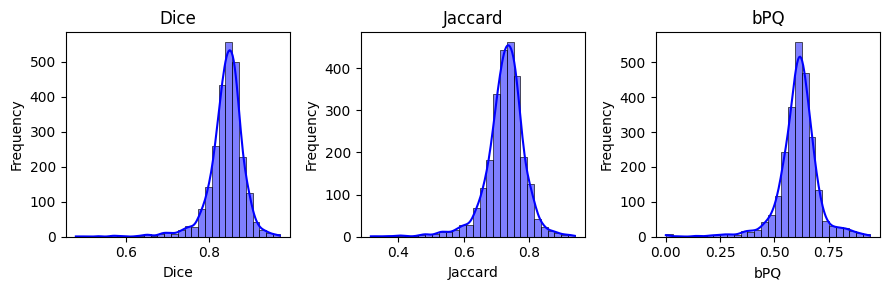

In [144]:
plot_all_metrics(df_metrics)

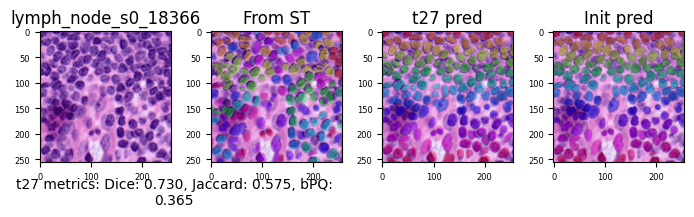

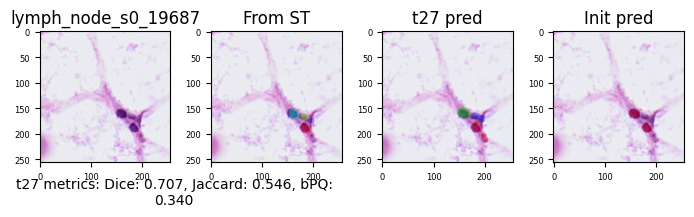

In [145]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [146]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for ovary_s0

In [147]:
slide_id = "ovary_s0"

In [148]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
317     ovary_s0_2467  0.706054  0.545660  0.376292   
332     ovary_s0_2482  0.689336  0.525944  0.461609   
334     ovary_s0_2484  0.794224  0.658683  0.594478   
336     ovary_s0_2486  0.736237  0.582576  0.408516   
359     ovary_s0_2579  0.730775  0.575765  0.398905   
...               ...       ...       ...       ...   
10215  ovary_s0_21495  0.875747  0.778959  0.623166   
10218  ovary_s0_21498  0.860544  0.755224  0.642202   
10221  ovary_s0_21609  0.873743  0.775794  0.636439   
10222  ovary_s0_21610  0.875731  0.778934  0.497404   
10226  ovary_s0_21614  0.872213  0.773384  0.584472   

                                   type_proba_per_nuclei  
317    {'Dead': 0.8412698368186782, 'Epithelial': 0.4...  
332    {'Dead': 0.8703703623113855, 'Blood_vessel': 0...  
334    {'Dead': 0.7623762300754829, 'Fibroblast_Myofi...  
336    {'Dead': 0.8812785347886825, 'Fibroblast_Myofi...  
359    {'Dead': 0.9999999940476191, 'Fibroblast_Myofi...  
...                                                  ...  
10215  {'Epithelial': 0.9417808186925315, 'Fibroblast...  
10218  {'Epithelial': 0.9409090866322314, 'Myeloid': ...  
10221  {'Epithelial': 0.9541666626909723, 'B_Plasma':...  
10222                 {'Epithelial': 0.9667774054259887}  
10226  {'Epithelial': 0.9511278159732037, 'Myeloid': ...  

[1751 rows x 5 columns]

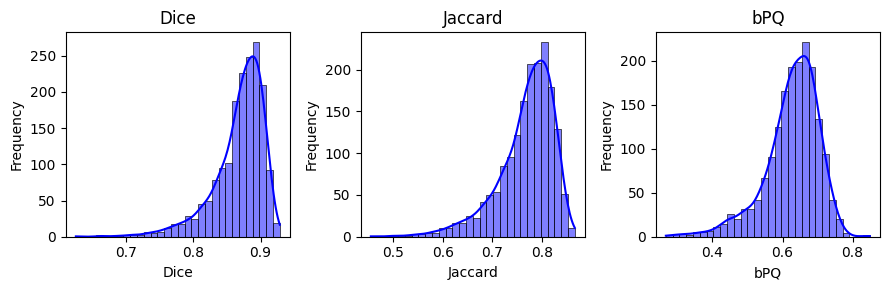

In [149]:
plot_all_metrics(df_metrics)

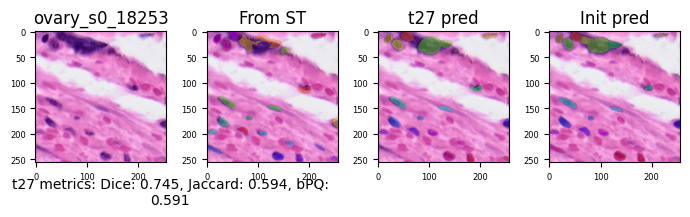

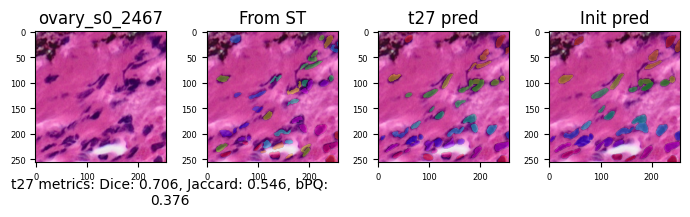

In [150]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [151]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for ovary_s1

In [152]:
slide_id = "ovary_s1"

In [153]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
29       ovary_s1_524  0.863225  0.759363  0.585485   
31       ovary_s1_526  0.869967  0.769860  0.655240   
40       ovary_s1_535  0.851142  0.740859  0.495466   
41       ovary_s1_536  0.877032  0.780994  0.615973   
45       ovary_s1_540  0.859098  0.753000  0.574085   
...               ...       ...       ...       ...   
25895  ovary_s1_35177  0.900635  0.819232  0.812856   
25897  ovary_s1_35179  0.829892  0.709244  0.519900   
25922  ovary_s1_35314  0.890132  0.802016  0.713573   
25950  ovary_s1_35344  0.899728  0.817732  0.684535   
25954  ovary_s1_35349  0.841683  0.726644  0.619509   

                                   type_proba_per_nuclei  
29     {'Epithelial': 0.9683794428127295, 'Myeloid': ...  
31     {'Epithelial': 0.9776119330028961, 'Myeloid': ...  
40     {'Epithelial': 0.8064515868886585, 'Myeloid': ...  
41     {'Myeloid': 0.5161290267082901, 'Epithelial': ...  
45     {'Blood_vessel': 0.9741379268356124, 'Fibrobla...  
...                                                  ...  
25895  {'Dead': 0.8727272647933885, 'Fibroblast_Myofi...  
25897  {'Fibroblast_Myofibroblast': 0.975133213188040...  
25922  {'Fibroblast_Myofibroblast': 0.983132527751487...  
25950  {'Blood_vessel': 0.9999999903846155, 'Fibrobla...  
25954  {'Blood_vessel': 0.9664179068417242, 'Fibrobla...  

[4408 rows x 5 columns]

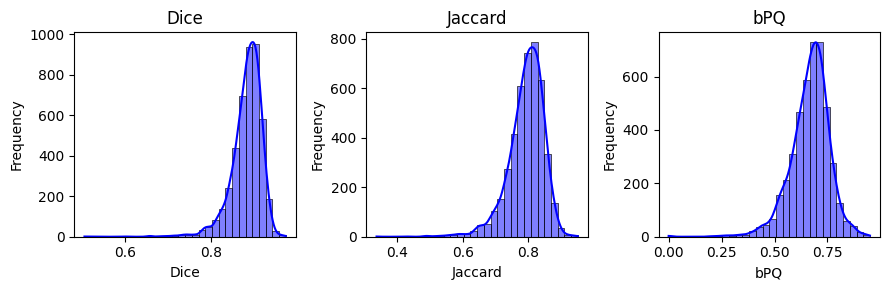

In [154]:
plot_all_metrics(df_metrics)

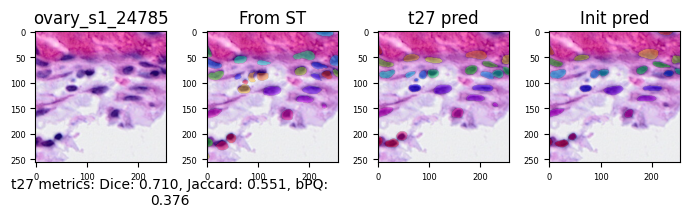

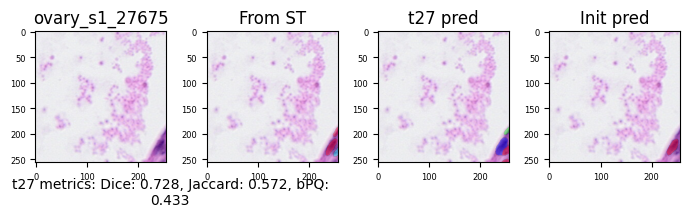

In [155]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [156]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for prostate_s0

In [157]:
slide_id = "prostate_s0"

In [158]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
19      prostate_s0_4064  0.710922  0.551497  0.438089   
20      prostate_s0_4065  0.763141  0.616999  0.390873   
22      prostate_s0_4067  0.764196  0.618380  0.524247   
59      prostate_s0_4104  0.735435  0.581571  0.338889   
83      prostate_s0_4128  0.740714  0.588202  0.412753   
...                  ...       ...       ...       ...   
13532  prostate_s0_32232  0.781723  0.641663  0.424704   
13533  prostate_s0_32233  0.846156  0.733337  0.574061   
13540  prostate_s0_32349  0.846702  0.734157  0.588188   
13546  prostate_s0_32355  0.857427  0.750435  0.581916   
13547  prostate_s0_32356  0.850549  0.739962  0.590191   

                                   type_proba_per_nuclei  
19     {'Dead': 0.931623923661334, 'Fibroblast_Myofib...  
20                 {'Blood_vessel': 0.25806451196670144}  
22     {'Blood_vessel': 0.9999999963369963, 'Dead': 0...  
59                          {'Dead': 0.9914163047578699}  
83     {'Dead': 0.1690140837135489, 'Fibroblast_Myofi...  
...                                                  ...  
13532  {'Epithelial': 0.9489795821532696, 'Myeloid': ...  
13533  {'Epithelial': 0.9275362184415041, 'Myeloid': ...  
13540  {'Epithelial': 0.9915611772507967, 'Fibroblast...  
13546  {'Fibroblast_Myofibroblast': 0.992957739486213...  
13547  {'Blood_vessel': 0.999999989130435, 'Fibroblas...  

[2452 rows x 5 columns]

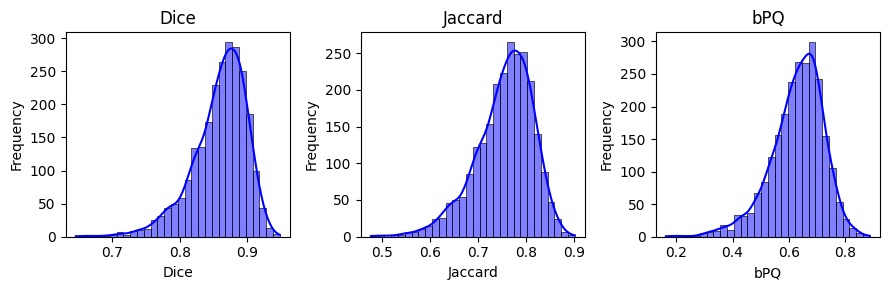

In [159]:
plot_all_metrics(df_metrics)

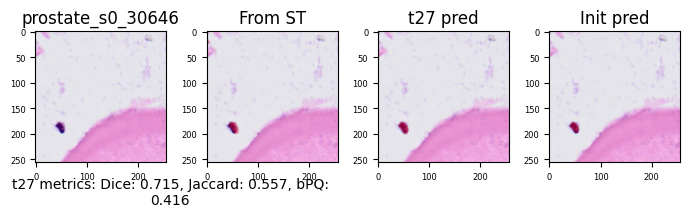

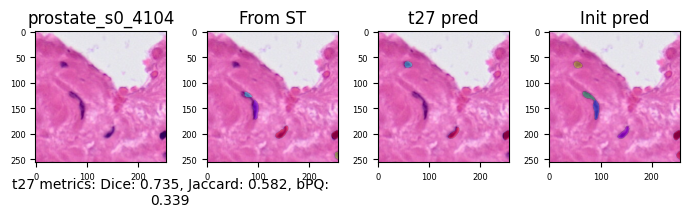

In [160]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [161]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for cervix_s0

In [162]:
slide_id = "cervix_s0"

In [163]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
25      cervix_s0_3003  0.837466  0.720379  0.600967   
26      cervix_s0_3004  0.847920  0.735991  0.625639   
33      cervix_s0_3011  0.791764  0.655306  0.589358   
37      cervix_s0_3015  0.877014  0.780966  0.712729   
38      cervix_s0_3016  0.812244  0.683847  0.620036   
...                ...       ...       ...       ...   
36540  cervix_s0_46222  0.808029  0.677894  0.510919   
36564  cervix_s0_46400  0.718204  0.560310  0.339808   
36573  cervix_s0_46413  0.680015  0.515169  0.430752   
36581  cervix_s0_46421  0.821385  0.696907  0.539061   
36582  cervix_s0_46422  0.870554  0.770780  0.627319   

                                   type_proba_per_nuclei  
25     {'Epithelial': 0.9836065412523518, 'Fibroblast...  
26                    {'Epithelial': 0.9999999795918372}  
33     {'T_NK': 0.9735099273277489, 'Fibroblast_Myofi...  
37     {'Epithelial': 0.9999999833333336, 'Fibroblast...  
38     {'Fibroblast_Myofibroblast': 0.984282905728324...  
...                                                  ...  
36540  {'Dead': 0.5396825311161503, 'T_NK': 0.6990291...  
36564  {'Fibroblast_Myofibroblast': 0.995305162761650...  
36573  {'Epithelial': 0.39116719119505616, 'Dead': 0....  
36581  {'T_NK': 0.9189189166611329, 'Fibroblast_Myofi...  
36582  {'T_NK': 0.8148148117969822, 'Myeloid': 0.9843...  

[7099 rows x 5 columns]

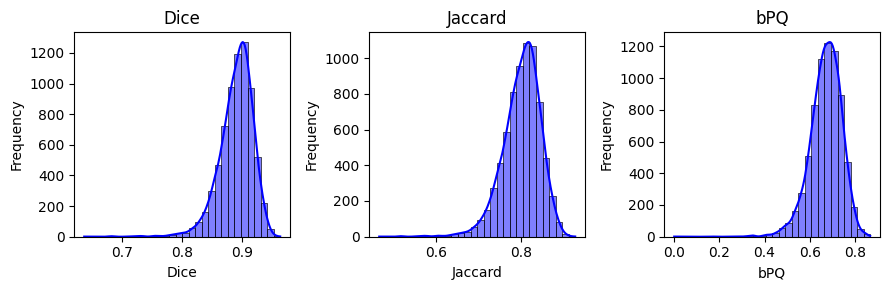

In [164]:
plot_all_metrics(df_metrics)

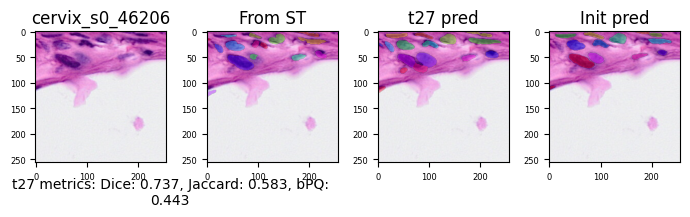

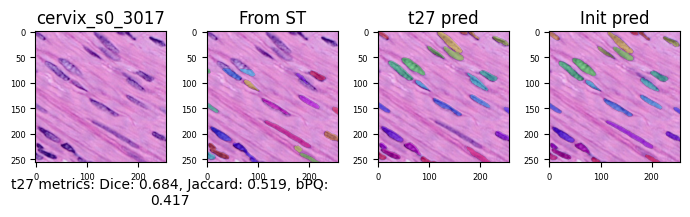

In [165]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [166]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)